# JUKES-CANTOR


## Clustering techniques on protein families


#### Aim of the project

The aim of the project is to apply the PCA clustering algorithm to the sequences associated to a certain PFAM to see whether they are connected to a taxonomic level (order, family or genus) of the proteome to which they belong or not.

#### Assignments

* define a proper distance between strings of possibly different lengths (e.g. maximum overlap)
* calculate the distance between each pair of nucleotidic sequence thus building the distance matrix
* apply the PCA to this matrix
* colour the points in the first two principal components according to a fixed taxonomic level (TaxaTab)

## Data pre-processing


#### Sequences database

The database *SequencesCorePFAM_PF0053.txt* should contain 

* in odd lines the information on the proteome to which the PFAM belongs and the protein in which it has been found.
* in even lines the amino-acid sequences associated to that PFAM in such a proteome.

We noticed that data were not as expected: some lines in the file were not ordered as "odd" and "even", so we made a small script to write a new file with the correct ordering

Then we realized that we would rather have the information contained in the column *Proteome_&_Protein_ID*, split into two different columns: proteomes and protein IDs.


#### TaxaTab database

In the database *TaxaTab_proteomes_bacteria.csv* all rows had the same values for both "superkingdom" and "kingdom". So we discarded them, as they were non informative.

As a final step, we merged the two datasets into one single dataset, on which we associated a taxonomic address to each proteome ID

In [2]:
#package-importing cell 
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering as AC
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import DBSCAN

In [3]:
import warnings; warnings.simplefilter('ignore')

##### the following cell is not to be run

    #loading file
    infile_name = "SequencesCorePFAM_PF00453.txt"
    infile = open(infile_name,'r')
    #line counter
    line_c = 0

    #support lists
    app_name = []
    app_seq = []

    #iterating along the file and filling lists
    for line in infile:

        line = line[:-1]
        if ">" in str(line):
            app_name.append(line)
        else:
            app_seq.append(str("\"" + line[1:-2] + "\""))
        line_c += 1

    infile.close()

    #writing to file
    outfile_name = "SequencesCorePFAM_PF00453_new.csv"
    outfile = open(outfile_name, 'w')
    outfile.write("Proteome_&_Protein_ID"+","+"Sequence\n")
    for i in range(len(app_name)):
        app = str(app_name[i]+ "," + app_seq[i] + "\n")
        outfile.write(app)

    outfile.close()

##### the following cell is not to be run

    #visualizing newly written file
    file_name = "SequencesCorePFAM_PF00453_new.csv"
    seq=pd.read_csv(file_name)
    #seq  #<- remove hastag to visualize seq

Here, we realized that when data is presented as we did, its usefulness is limited: we would rather have proteomes and protein IDs in separated columns. To do so, we implemented the following script.


##### the following cell is not to be run

    #here we defined two numpy arrays, in which we will save the pertaining parts of the strings
    #namely, the proteome ID and the protein ID
    proteome = np.array(app_name)
    protein = np.array(app_name)

    #simultaneous assignment by using split
    for i in range(len(proteome)):
        proteome[i], protein[i] = proteome[i][2:-1].split(".tsv/")

    #writing out

    outfile_name = "SequencesCorePFAM_PF00453_final.csv"
    outfile = open(outfile_name, 'w')
    outfile.write("Proteome,Protein_Id,Sequence" + "\n")
    for i in range(len(app_name)):
        app = str(proteome[i]+ ",\"" + protein[i] + "\"," + app_seq[i] + "\n")
        outfile.write(app)

    outfile.close()

In [4]:
#visualizing the properly separated dataframe
file_name = "SequencesCorePFAM_PF00453_final.csv"
prot=pd.read_csv(file_name)
#prot

In [5]:
#visualizing the taxonomic dataset
file_name = "TaxaTab_proteomes_bacteria.csv"
specie=pd.read_csv(file_name)

All rows have the same values for both "superkingdom" and "kingdom". As such, we discarded them, as they were non informative.

In [6]:
#dropping noninformative columns
specie = specie.drop(['superkingdom'], axis=1)
specie = specie.drop(['kingdom'], axis=1)

As a final step, we merged the two datasets into one single dataset, on which we associated a taxonomic address to each proteome ID.

In [7]:
#using merge to unite the datasets
specie = specie.rename(index=str, columns={"ncbi ID": "Proteome"})
final = pd.merge(prot,specie, on="Proteome")
final

Proteome  Protein_Id                                           Sequence  \
0      1000565      F5REM1  RVKRGVTARARHKKVLDQAKGYRGRRKSVYRIAKEAVMKAGQYAYR...   
1      1000569      F9MPY1  RIKVGVTAHARHKKIVKMAKGYRGTRSRLFKKANESVMKALFYARR...   
2      1001240  A0A099JN25  RVKRAVNAHKKRRVILERAKGYRGQRSRLVRKAKEQVTHSFVYSYR...   
3      1001886  A0A090RDG9  RVKRGVQARARHKKVLKQAKGYYGARSRVYRVAFQAVTKAGQYAYR...   
4       100226      O88058  RVKRAVNAHKKRRAILEQASGYRGQRSRLYRKAKEQVTHSLVYNYN...   
5      1002340  A0A0B4FBU3  RVKGGTTTHARHKKVIKAAKGYYGRRKNTFKVARQAVDKANQYATR...   
6      1002368      G9Z8M6  RVKRGVIARARHKKILKQAKGYYGARSRVYRVAFQAVIKAGQYAYR...   
7      1002672      F2I080  RVKRGQASHQKHKKVFKQAKGFRGRRKNTIRVAKQAVEKSLQYAYR...   
8      1002804      F8KSE9  RVKTGVVRRRRHKKVLKQARGFYSGRRKHFRKAKEQLERSLCYAFR...   
9      1002805      H5V8Y1  RVKTGVVRRRRHKKVLKQARGFFSGRRKHFRKAKEQLERSLCYAFR...   
10     1002809      F2F906  RVKGGTVTRARRKKVLKLAKGYYGSKHTLYKVANQAVMKSGQYAYR...   
11        1003  A0A1I2CJ66  RSVNSVASRARRKKILKLTKGNFLARRNVWTVAKNTLEKGLLHAYV...   
12     1003181  A0A0A6PFX6  RVKRGVTAHAKHKKILDAAKGYRGARRNVLRVAKQAVTKAGQYAYR...   
13     1003195      F8K2Q5  RVKRAVNAHKKRRAILEQASGYRGQRSRLYRKAKEQVTHSLVYNYN...   
14     1003200      F7T564  MRAGQYAYRDRRNKKRTFRALWITRINAAVREHGVSYSVFIAGLKK...   
15        1004  A0A1K1N9E3  RSVNAVASRARRKKILKQAKGFYGKRKNVYTVAKNVLEKGLTYSYV...   
16     1004785      K0CZN6  RVKRGTIARARHKKVLKQAKGYYGARSRVYRVAVQAVTKAGQYAYR...   
17     1004836      F3SEV8  KRGVTTHARHKKVLELSKGFRGRSSTNYRIALERLEKSLQYAYRDR...   
18     1005043      G2H0P3  RVKRGVVARARHKKILKQAKGYYGARSRVYRVAFQAVIKAGQYAYR...   
19     1005048      G0ABC9  RVKRGVTARARHKKILVQAKGYRGRRSKVYRVAKQAVMRAGQYAYR...   
20     1005058      F4HCD3  RVKRGVIARARHKKILKAAKGYYGARSRVYRVAFQAVIKAGQYAYR...   
21     1005395      L1M7X9  RVKRGVIARKRHKKILKLAKGYYGARSRVFRVAKQAVIKAGQYAYR...   
22     1005667  A0A1C4E7G6  RVKRGVIARARHKKILKQAKGYYGARSRVYRVAFQAVIKAGQYAYR...   
23     1005928  A0A1I5D2S7  RVKSGVVTHARHKKVIKAAKGYYGRRKNTFKVAAQAVDKANQYATR...   
24     1005944  A0A1H0GP63  RVKRAVNAQKKRRTTLERAAGYRGQRSRLYRKAKEQVTHSLVYSYN...   
25     1005945  A0A1I3KTH4  RVKRAVNAQKKRRTTLERAAGYRGQRSRLYRKAKEQVTHSLVYSYN...   
26     1005994  A0A085ANG6  RVKRGVIARARHKKILKQAKGYYGARSRVYRVAFQAVIKAGQYAYR...   
27     1005995  A0A085JDT5  RVKRGVIARARHKKILKQAKGYYGARSRVYRVAFQAVIKAGQYAYR...   
28     1005999  A0A085HJY2  MKQAKGYYGARSRVYRVAFQAVIKAGQYAYRDRRQRKRQFRQLWIA...   
29     1006000  A0A085HSD8  RVKRGVIARARHKKILKQAKGYYGARSRVYRVAFQAVIKAGQYAYR...   
...        ...         ...                                                ...   
7756    990712  A0A1G8ZI56  RVKGGTTTHARHKKVIKAAKGYYGRRKNTFKVARQAVDKANQYATR...   
7757    991905      F2J0A0  RVKRGVTAHARHKKVLKAAKGFYGRRKNTIRIAKQAVEKAAQYAYR...   
7758     99287      P0A7L6  RVKRGVIARARHKKILKQAKGYYGARSRVYRVAFQAVIKAGQYAYR...   
7759    993071  A0A0V8HUY5  RVKRAVNAHKKRRVVLERAKGYRGQRSRLYRKAKEQLLHSFVYSFN...   
7760    994573      V7I1X2  RVKRAVNAHKNHKKVLKLAKGYYGGKSKLFRTANETVIRALRNAYV...   
7761    995034  A0A1I5BHA1  RVKRAVNAHKKRRVILERAEGYRGQRSRLYRKAKEQVTHSMVYAYR...   
7762    995038  A0A1I3B207  RVKRAVNAHKSRRVILERAKGYRGQRSRLVTKAKEQLTHSFTYSYR...   
7763    995062  A0A1H1A329  RVKRAVHSQKKRRKVLESAKGYRGQRSRLYRKAKEQMLHSQVYSYR...   
7764    995066  A0A1G9F288  RVKRSVNAQKKRRKILESAKGYRGQRSRLYRKAKEQMLHSQVYSYR...   
7765     99598      K9PPE9  RVKRGNVARKRRNKILKLAKGFRGSHSTLFRTANQQVMKALRSAYR...   
7766    996342  A0A1M5X1C3  RVKGGTTTHARHKKVIKAAKGYYGRRKNTFKVARQAVDKANQYATR...   
7767     99656  A0A1I0R378  RIKGGLNAKKKHNRVLKLAKGYRGARSKQYRVAKQSVMRALTSSYA...   
7768    996637      F3NLA1  RVKRAVNAHKKRRAILEQASGYRGQRSRLYRKAKEQVTHSLVYNYN...   
7769    996801  A0A1B8U7B9  RSVNSVASRNRRKKILKAAKGYFGRRKNVYTVAKNAVEKGMLYAYR...   
7770    997346      F5SLL8  RVKGGTVTRRRRKKVLKLARGYFGSKHALFKTAKQQVMKSLSYAYR...   
7771    997347      F9EN85  RVKTGIIRRKRHKRVLKAAKGFRGASGDAFKQAKQATRKAMAYATR...   
7772    997350      G4D6A3  RIKRAVNAKKKHKKILKQAKGYFGAKSKLFRPANQAVMKSLNYAFA...   
7773    997352      F9D9A5  RSVNHVASK

In order to check the maximum and minimum lengths of the strings at hand.

In [8]:
final['lengths'] = pd.Series(final['Sequence'].apply(len), index=final.index)

print("\nThe length of the longest string is: ", final['lengths'].max(),)
print("\nThe length of the shortest string is: ", final['lengths'].min(), "\n")


The length of the longest string is:  113

The length of the shortest string is:  27 



## Taking a look at the raw data

We performed a quick visual analysis of the data. Each sequence was classified on a taxonomic basis: we grouped the dataset on the basis of its more general informative feature, namely, _phylum_. We then plotted the distribution of the data with respect to the different _phyla_. The following plot shows such distribution.

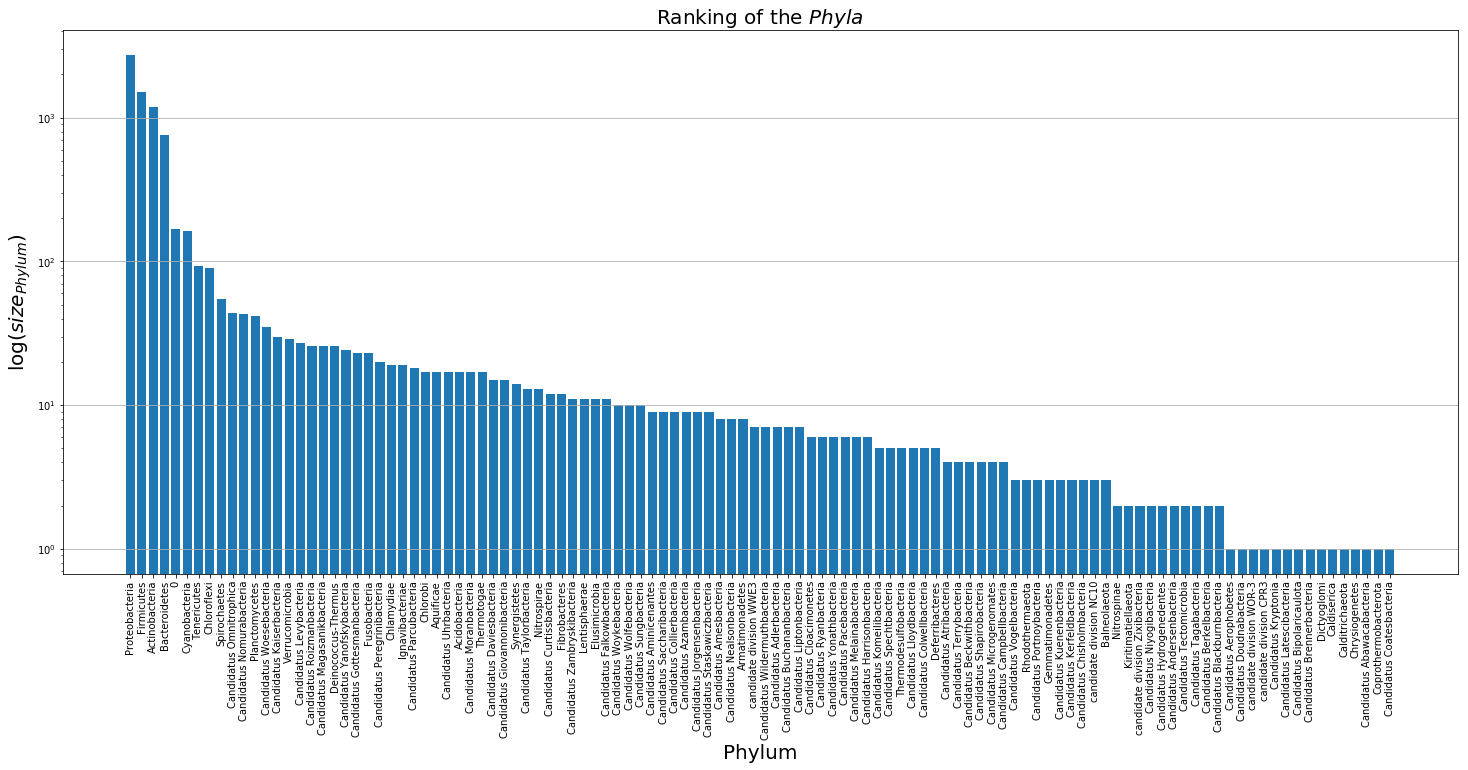

In [9]:
#ordering the phyla on the basis of the number of members in them
distr_phy_df=pd.DataFrame(final).groupby(['phylum']).count().sort_values(by='lengths', ascending=False)
distribution_phy = [distr_phy_df.index, distr_phy_df['lengths']]

#plotting the resulting distribution
plt.figure(figsize=(25,10))
plt.bar(distribution_phy[:][0],distribution_phy[:][1], log = True)
plt.xticks(rotation=90)
plt.xlabel("Phylum", fontsize=20)
plt.ylabel(r"$\log(size_{Phylum})$", fontsize=20)
plt.grid(axis='y')
plt.title(r'Ranking of the $Phyla$', fontsize=20)
plt.show()

We now plot the histogram of the various _Phyla_. The binning is logarithmic, as each _Phylum_ is placed in the bin whose range contains the number of elements in the _Phylum_ itself. The resulting histogram clearly shows that the dataset can be split in two parts:
 - many _Phyla_ contain few elements;
 - few _Phyla_ contain the majority of the elements.

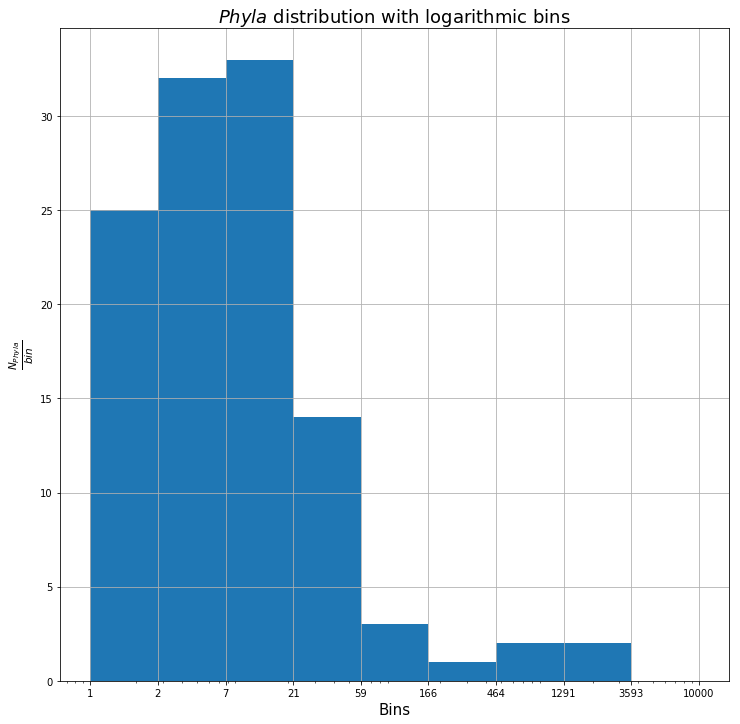

In [10]:
histo_phy_log = distr_phy_df['lengths'].values
bins=np.logspace(0,4,10)


plt.figure(figsize=(12,12))
plt.title(r"$Phyla$ distribution with logarithmic bins", fontsize=18)
plt.ylabel(r'$\frac{N_{Phyla}}{bin}$', fontsize=15)
plt.xlabel(r'Bins', fontsize=15)
plt.xscale(value='log')
plt.grid()
plt.xticks(bins, bins.astype(int))
plt.hist(histo_phy_log, bins=bins)
plt.show()

The overall distribution appears to be similar to a power law. One can quickly realize that a small minority of the _phyla_ are responsible for the majority of the whole dataset. As a consequence, the analysis can be restricted to a subset of the _phyla_, namely the minimum number of _phyla_ necessary to produce a (fixed and previously chosen) fraction of the whole dataset. 
Further classification was not studied, as adding more taxonomic identifiers would only fragment the dataset more; for all intents and purposes, a _phyla_-based classification is sufficient to suggest a power-law distribution of the data.

This reduction will be later employed, and it will prove to be useful, as it greatly reduces the number of "taxonomic" clusters, thus leading to more meaningful graphs.

__REMARK__ : the _phylum_ '0' was interpreted as a 'non-classification', and thus removed during later analysis as it was deemed non informative.

## Choosing a distance


#### "Generalized" Jukes-Cantor ansatz

The first distance we tried to implement takes inspiration from the *Jukes-Cantor* distance, which was originally invented to compare single RNA strands with same lenght. It is based on two assumptions:
 - each nucleotidic base equally likely to be substituted with another one;
 - each base constitutes the 25% of the total bases. 
 
We adapted these assumptons to match up with the fact that there are 20 amino acids (contrary to 4 nucleotidic bases). 

$$ d(x,y) =\min\limits_{\text{all possible p}} \left[-\frac{19}{20}\log\left(1-\frac{20}{19}p\right) \right] $$

Where $x$ and $y$ are amino acid sequences and $p$ is the relative frequency of the wrong ones.

The original Jukes-Cantor distance, however, was designed to be used on same-length strings. As our sequences had different lengths, we decided to use a *maximum overlap* paradigm: each couple of strings was 'scrolled' on one another, and for each overlap, the J-C distance was computed. The minimum of all these distances was set as the distamce between the two strings. This also applies for $180°$ rotations so we computed the distances also with one of the two sequences flipped.

## APPROACH TO DATA ANALYSIS

The following approach will be followed throughout the remainder of the notebook.

For each distance prescription:
 - we first compute the distance matrix, defined as the square matrix whose elements are the distances between each couple of strings;
 - we then perform PCA in order to reduce data dimensionality, and plot the different clusters that were obtained by both taxonomic classification and an unsupervised clustering (namely, a single link agglomerative clustering);
 - we then trimmed the dataset by both keeping only the most informative _phyla_ and by ditching the '0' _phylum_ and perform PCA and clustering on this new dataset.


# JUKES-CANTOR DISTANCE

## Calculating the distance matrix

The distance matrix was calulated via some python macros specifically designed to reduce and 'parallelize' the computation as much as possible. In the appendix there is the code to compute the matrix.  The distance matrix is loaded in the following cell.

In [11]:
data_cantor = np.loadtxt("dist_Cantor.csv", delimiter=",", skiprows=1)

We now load the data into a dataframe to have a better view.

In [12]:
Df_cantor = pd.DataFrame(data_cantor)
Df_cantor.columns.names=['Sequences']
Df_cantor

Sequences      0         1         2         3         4         5     \
0          0.000000  0.522451  0.607101  0.296536  0.607101  0.894372   
1          0.522451  0.000000  0.607101  0.465369  0.643193  0.995397   
2          0.607101  0.607101  0.000000  0.615154  0.231699  1.236814   
3          0.296536  0.465369  0.615154  0.000000  0.579768  0.837562   
4          0.607101  0.643193  0.231699  0.579768  0.000000  1.345921   
5          0.894372  0.995397  1.236814  0.837562  1.345921  0.000000   
6          0.319088  0.459773  0.700040  0.109891  0.538788  0.918639   
7          0.506389  0.700040  0.739919  0.512721  0.781547  0.847622   
8          0.661766  0.719770  0.894372  0.597296  0.719770  1.138958   
9          0.661766  0.719770  0.894372  0.615154  0.719770  1.170470   
10         0.475059  0.490595  0.661766  0.391344  0.700040  0.870710   
11         0.815050  0.815050  1.068532  0.771564  1.012136  1.159949   
12         0.345608  0.475059  0.522451  0.309514  0.522451  0.825083   
13         0.589557  0.607101  0.231699  0.579768  0.038139  1.345921   
14         0.319649  0.494856  0.651374  0.319649  0.651374  1.072692   
15         0.760505  0.781547  0.870710  0.709854  0.781547  1.170470   
16         0.293289  0.475059  0.661766  0.109891  0.538788  0.847622   
17         0.440333  0.552700  0.660874  0.440333  0.719960  0.923098   
18         0.306101  0.490595  0.643193  0.109891  0.555411  0.918639   
19         0.268172  0.555411  0.661766  0.258632  0.624976  0.870710   
20         0.306101  0.459773  0.624976  0.099359  0.522451  0.847622   
21         0.306101  0.490595  0.538788  0.198637  0.607101  0.894372   
22         0.319088  0.475059  0.700040  0.109891  0.538788  0.918639   
23         0.870710  0.969116  1.170470  0.837562  1.271809  0.057246   
24         0.555411  0.589557  0.243702  0.597296  0.208139  1.308142   
25         0.572331  0.607101  0.255858  0.633354  0.219846  1.426307   
26         0.319088  0.459773  0.700040  0.109891  0.538788  0.918639   
27         0.280647  0.475059  0.643193  0.099359  0.538788  0.894372   
28         0.335431  0.486009  0.622234  0.103238  0.486009  0.942720   
29         0.306101  0.475059  0.680710  0.120542  0.522451  0.894372   
...             ...       ...       ...       ...       ...       ...   
7756       0.870710  0.969116  1.203063  0.860622  1.308142  0.067132   
7757       0.345608  0.555411  0.643193  0.465369  0.643193  0.680710   
7758       0.306101  0.475059  0.680710  0.120542  0.522451  0.894372   
7759       0.607101  0.700040  0.173860  0.633354  0.219846  1.345921   
7760       0.680710  0.607101  0.624976  0.545653  0.607101  1.108458   
7761       0.589557  0.607101  0.077873  0.562557  0.231699  1.271809   
7762       0.624976  0.607101  0.067782  0.615154  0.293289  1.271809   
7763       0.643193  0.607101  0.280647  0.579768  0.280647  1.385264   
7764       0.643193  0.555411  0.268172  0.579768  0.268172  1.426307   
7765       0.562557  0.545653  0.633354  0.562557  0.670834  1.068532   
7766       0.894372  0.969116  1.203063  0.837562  1.308142  0.009305   
7767       0.719770  0.643193  0.739919  0.615154  0.661766  1.108458   
7768       0.607101  0.624976  0.243702  0.579768  0.009392  1.345921   
7769       0.579768  0.771564  0.860622  0.597296  0.729982  0.958901   
7770       0.607101  0.538788  0.661766  0.597296  0.661766  0.969116   
7771       0.661766  0.719770  0.943542  0.597296  0.943542  1.022426   
7772       0.643193  0.572331  0.624976  0.562557  0.506389  1.138958   
7773       0.661766  0.781547  0.870710  0.651909  0.870710  1.050246   
7774       0.572331  0.607101  0.319088  0.579768  0.319088  1.385264   
7775       0.760505  0.781547  0.555411  0.633354  0.555411  1.308142   
7776       0.615154  0.670834  0.815050  0.615154  0.837562  1.039916   
7777       0.700040  0.538788  0.680710  0.529044  0.680710  1.138958   
7778       0.680710  0.643193  0.700040  0.615154  0.70004

## Preliminary analysis on the distance matrix

The distance matrix we obtained by using the Damerau-Levenshtein distance can be analyzed via a histogram. The result will be a distribution of the distances, from which one can obtain the likelihood of a given distance.

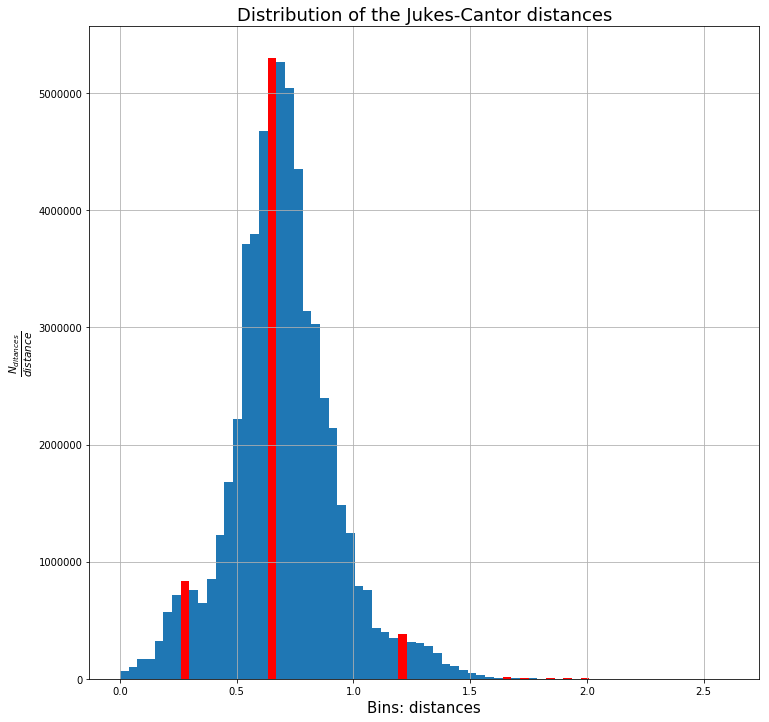

The peak distances are the following:
 [0.26065799 0.63302654 1.19157937 1.63842163 1.71289534 1.82460591
 1.89907962 1.97355333 2.04802704 2.12250075 2.23421132]
[ 7 17 32 44 46 49 51 53 55 57 60]

Reltive weights of peaks:

834940.0
5304374.0
386410.0
11450.0
4520.0
2802.0
3594.0
3094.0
2002.0
608.0
166.0


In [13]:
data_hist = data_cantor.flatten()

n_bins = 70

fig, ax = plt.subplots(figsize=(12,12))

plt.xlabel(r'Bins: distances', fontsize=15)
plt.ylabel(r'$\frac{N_{ditances}}{distance}$', fontsize=15)
plt.title('Distribution of the Jukes-Cantor distances', fontsize=18)
plt.grid()

N, _, patches = ax.hist(data_hist, bins =n_bins)

#finding the peaks
dt_hst, bin_edges = np.histogram(data_hist, bins=n_bins)
bin_width = bin_edges[1]-bin_edges[0]
max_indx = signal.find_peaks(dt_hst)

# mettere larghezza bin

#plotting the peaks
for i in max_indx[0]:
    patches[i].set_facecolor('r')
    
plt.show()


print("The peak distances are the following:\n", max_indx[0]*bin_width)
print(max_indx[0])

print("\nReltive weights of peaks:\n")
for i in max_indx[0]:
    print(patches[i].get_height())


Looking at the heigths of the peaks one can see that only the first 3 peaks are relevant, the others are peaks that trick the algorithm, so they are not relevant.

## PCA on the whole dataset

In [14]:
# evaluating pca, only keeping 2 components

pca_function = PCA(n_components=2)
data_final = pca_function.fit_transform(data_cantor)

Results of the PCA procedure are now shown.

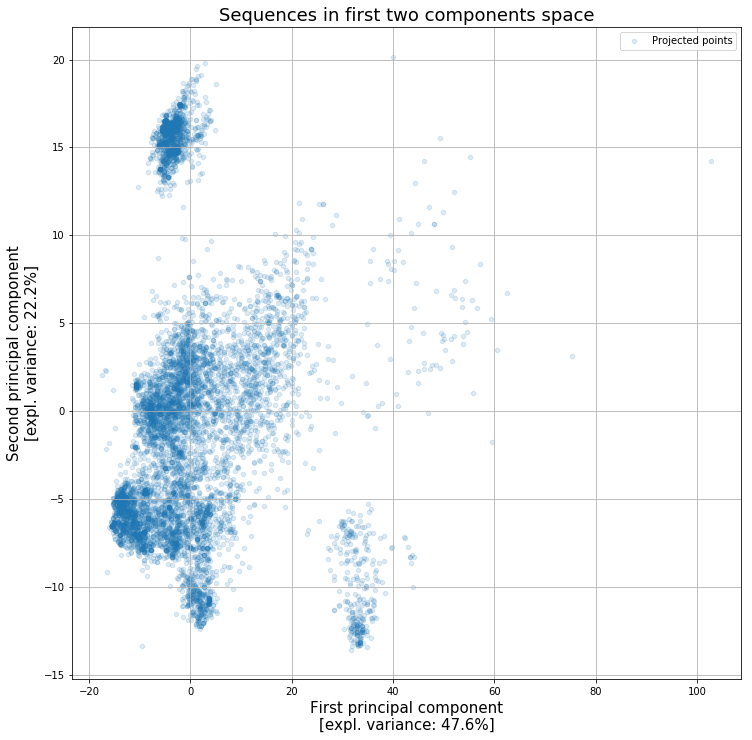

In [15]:
# plotting the whole PCA results on the whole matrix
fig, ax = plt.subplots(figsize = (12, 12))
plt.scatter(data_final[:,0], data_final[:,1], alpha=0.15, s=20, label='Projected points')

ax.set_title('Sequences in first two components space', fontsize = 18)
ax.set_xlabel('First principal component\n[expl. variance: ' 
              + str("{:.1f}".format(pca_function.explained_variance_ratio_[0]*100)) + '%]', fontsize = 15)
ax.set_ylabel('Second principal component\n[expl. variance: '
              + str("{:.1f}".format(pca_function.explained_variance_ratio_[1]*100)) + '%]', fontsize = 15)
boundx=ax.get_xbound()
boundy=ax.get_ybound()
ax.grid(True)
plt.legend()
plt.show()

Some clustering is apparent. We now prepare to plot each unique taxonomic group (up to the order) in order to see if they follow some form of clustering. Some utility follows.

In [16]:
# Here we want to divide the sequences w.r.t. their classification:
# to do it, we consider the triplets of [phylum, class, order]

# reorganizing the data: each 'group...' array contains the indexes of the elements in each class
#each "by_..." array contains the names of the classes

group_phylum = []
by_phylum = np.unique(final["phylum"])
for phy in by_phylum:
    group_phylum.append(final.index[final["phylum"]==phy].tolist())

group_class = []
by_class = np.unique(final["class"])
for cla in by_class:
    group_class.append(final.index[final["class"]==cla].tolist())

group_order = []
by_order = np.unique(final["order"])
for order in by_order:
    group_order.append(final.index[final["order"]==order].tolist())

# list that will contain the list of different triplets
super_group = []

#we are selecting the unique triplets of which the dataset is composed.
for phy in by_phylum:
    for cla in np.unique(final[final["phylum"]==phy]["class"]):
        for order in np.unique(final[final["phylum"]==phy][final["class"]==cla]["order"]):
            super_group.append([phy,cla,order])

print("Number of phyla:\t", len(by_phylum))
print("Number of classes:\t", len(by_class))
print("Number of orders:\t", len(by_order))

# here we create the lists of indeces corresponding to every triplet
cluster = []
cluster2 = []
for index in super_group:
    cluster.append(final[final["phylum"]==index[0]][final["class"]==index[1]][final["order"]==index[2]].index.tolist())
    
super_group2 = []

#we are selecting the unique triplets of which the dataset is composed.
for phy in by_phylum:
    for cla in np.unique(final[final["phylum"]==phy]["class"]):
            super_group2.append([phy,cla,order])

for index2 in super_group2:
    cluster2.append(final[final["phylum"]==index2[0]][final["class"]==index2[1]].index.tolist())

Number of phyla:	 112
Number of classes:	 78
Number of orders:	 170


We now plot each phylum that has at least 50 elements (arbitrary choice) as a standalone graph.

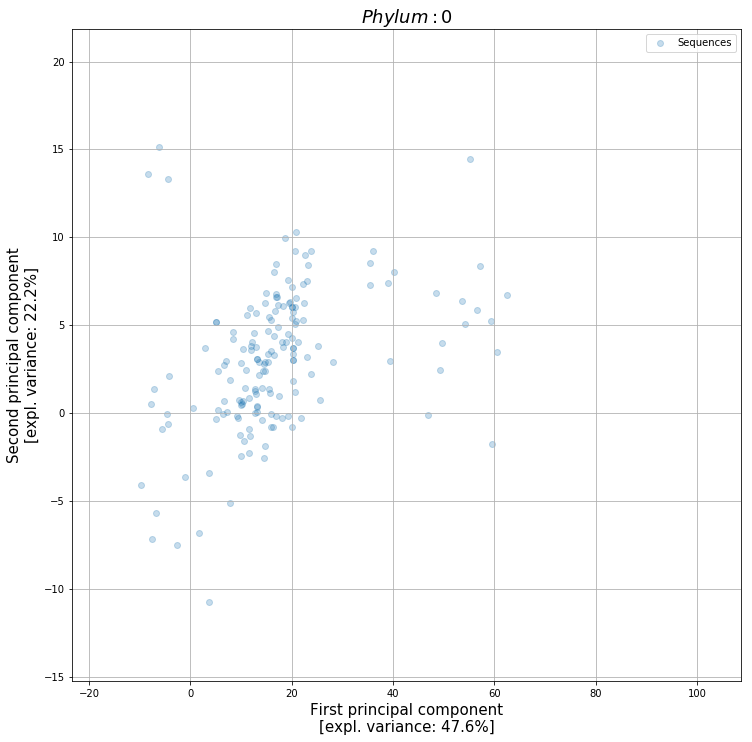

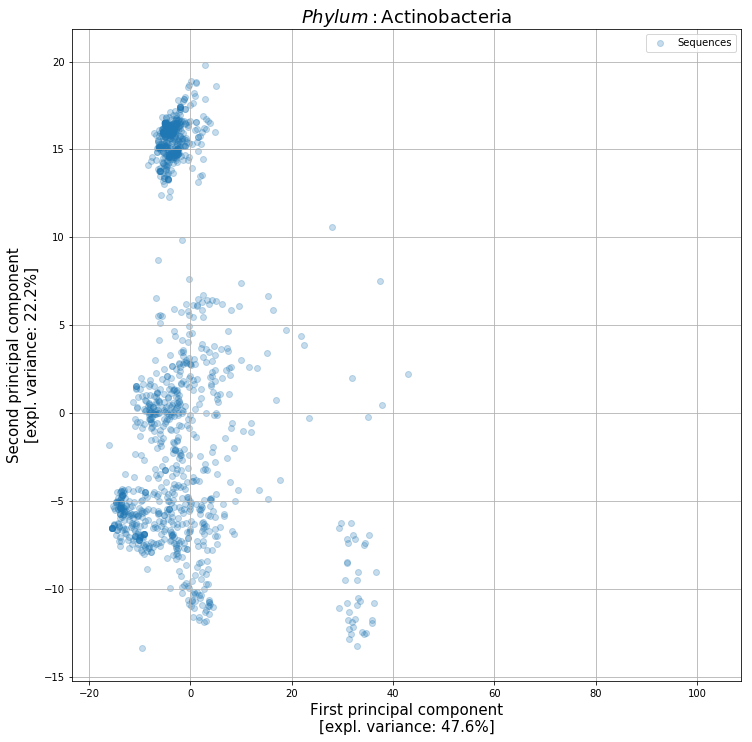

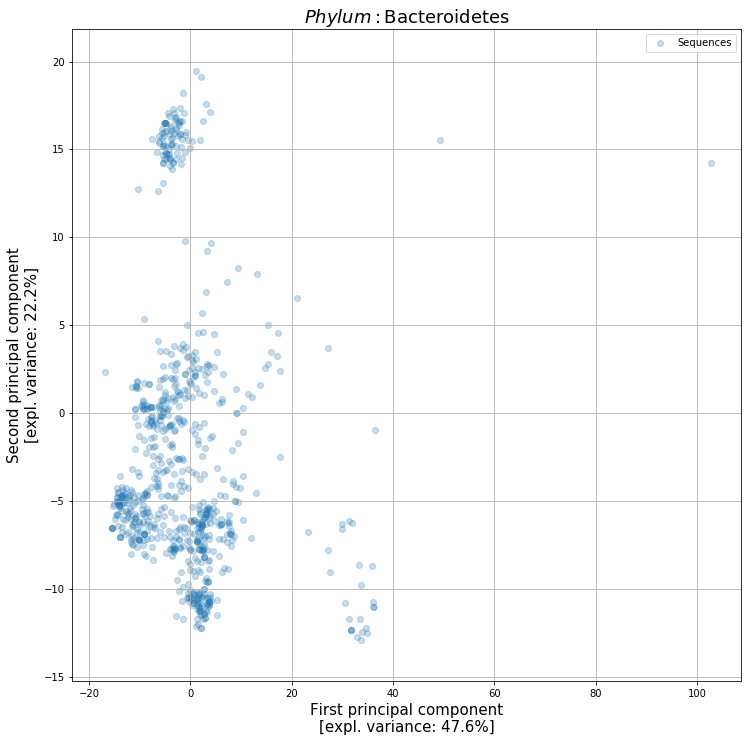

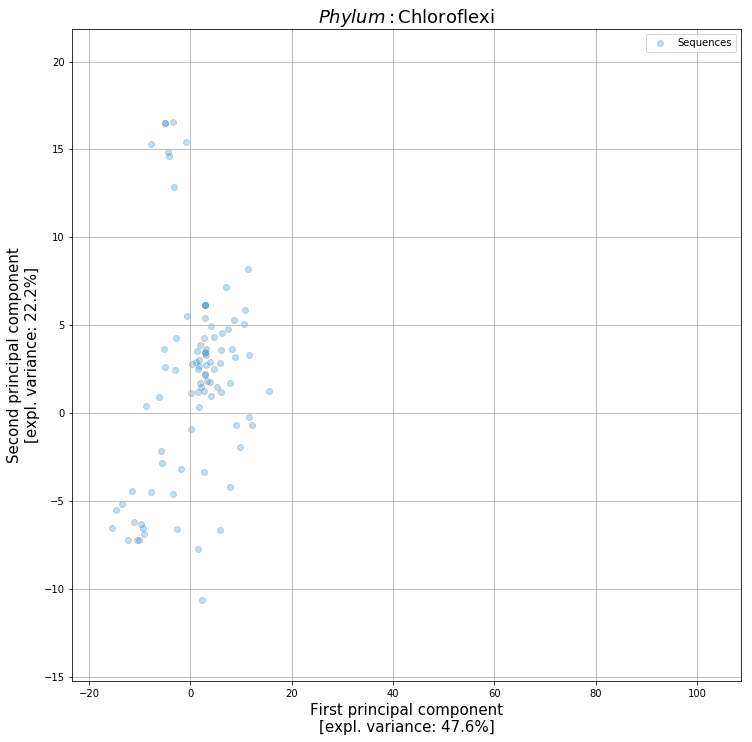

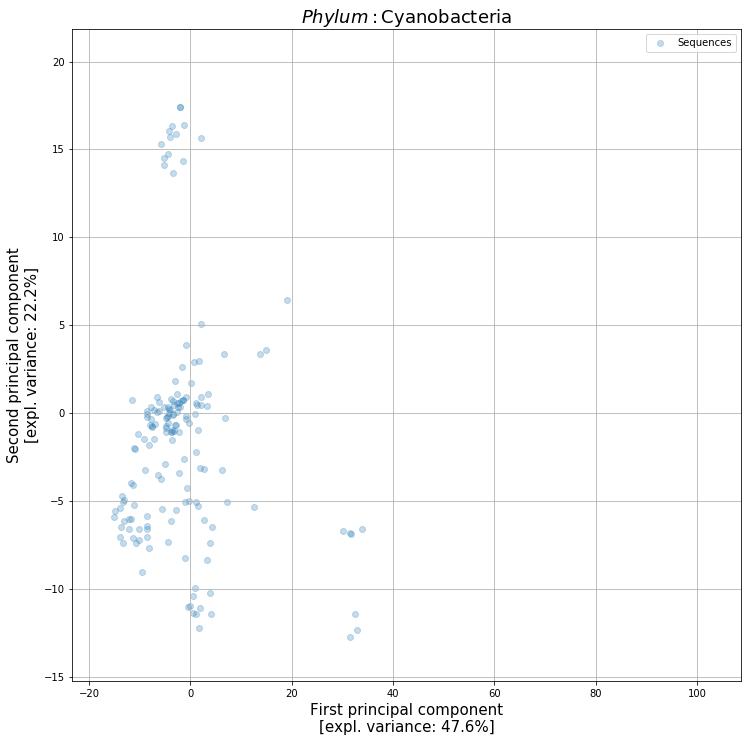

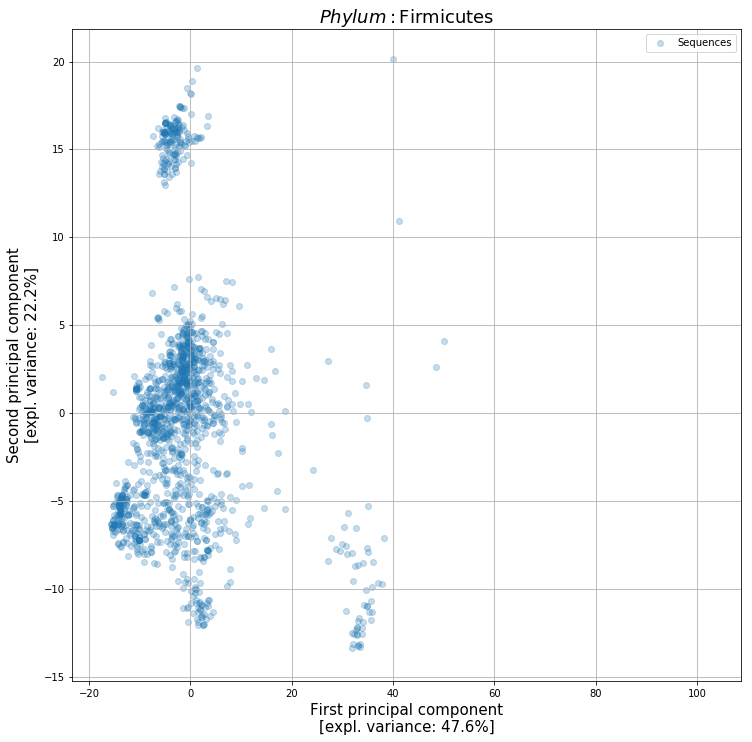

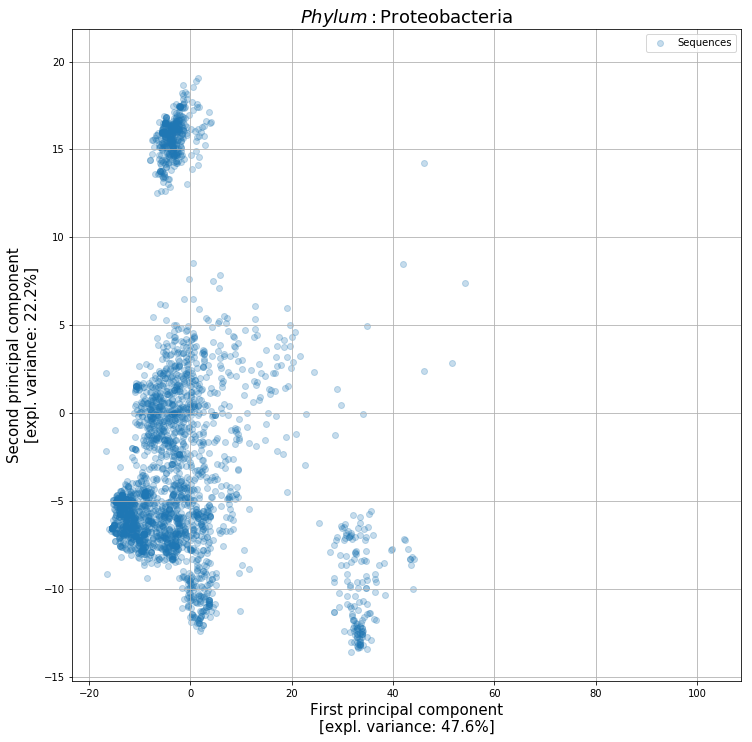

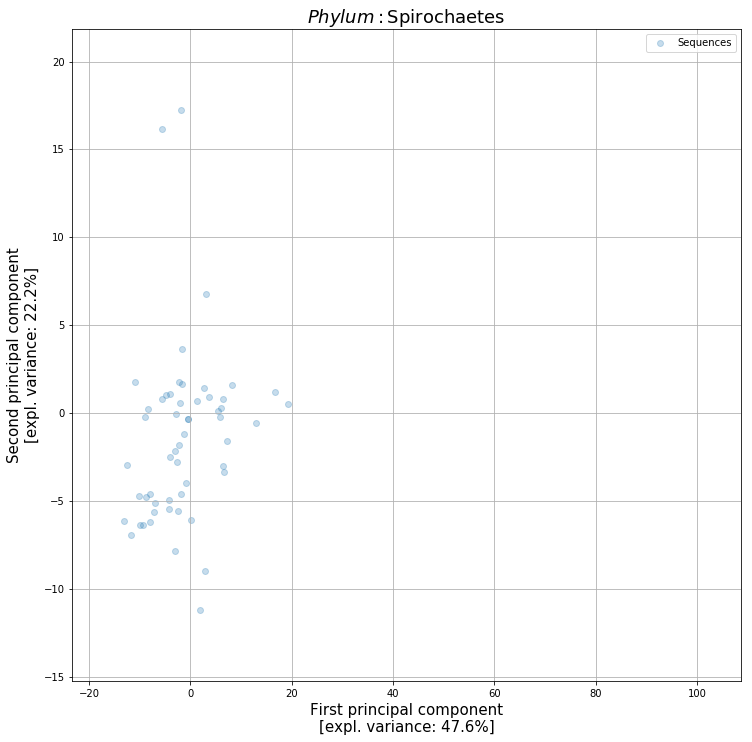

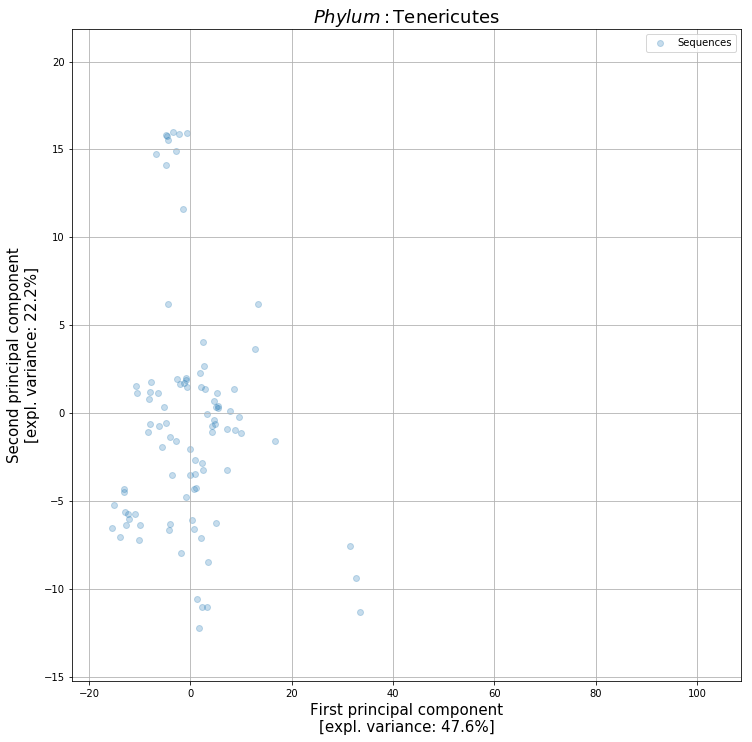

In [17]:
#plotting phyla groups of at least 50 elements

# preparing to plot
data_plot = []

# iterating in the phylum list and plotting the corresponding PCA data
for i_phy in range(len(group_phylum)):
    
    data_plot = []
    for i in group_phylum[i_phy]:
        data_plot.append(data_final[i-1].tolist())

    if len(data_plot) > 50:
        data_plot = np.array(data_plot)
        plt.figure(figsize=(12,12))
        plt.scatter(data_plot[:,0], data_plot[:,1], alpha=0.25, label = 'Sequences')
        # fixing figure dimensions to compare each data to the whole data distribution
        plt.ylim(boundy[0],boundy[1])
        plt.xlim(boundx[0],boundx[1])
        plt.grid()
        plt.xlabel('First principal component\n[expl. variance: ' 
              + str("{:.1f}".format(pca_function.explained_variance_ratio_[0]*100)) + '%]', fontsize = 15)
        plt.ylabel('Second principal component\n[expl. variance: '
              + str("{:.1f}".format(pca_function.explained_variance_ratio_[1]*100)) + '%]', fontsize = 15)


        plt.title(r'$Phylum:$' + str(final["phylum"][group_phylum[i_phy][0]]), fontsize = 18)
        plt.legend()
        # making the plot finish: a new plot will be made at every iteration
        plt.show()

We now plot each unique couple _Phylum-class_ whose members are more than 10 (as to prevent overcrowding) as a standalone graph. This subdivision of the dataset will prove to be rather interesting.

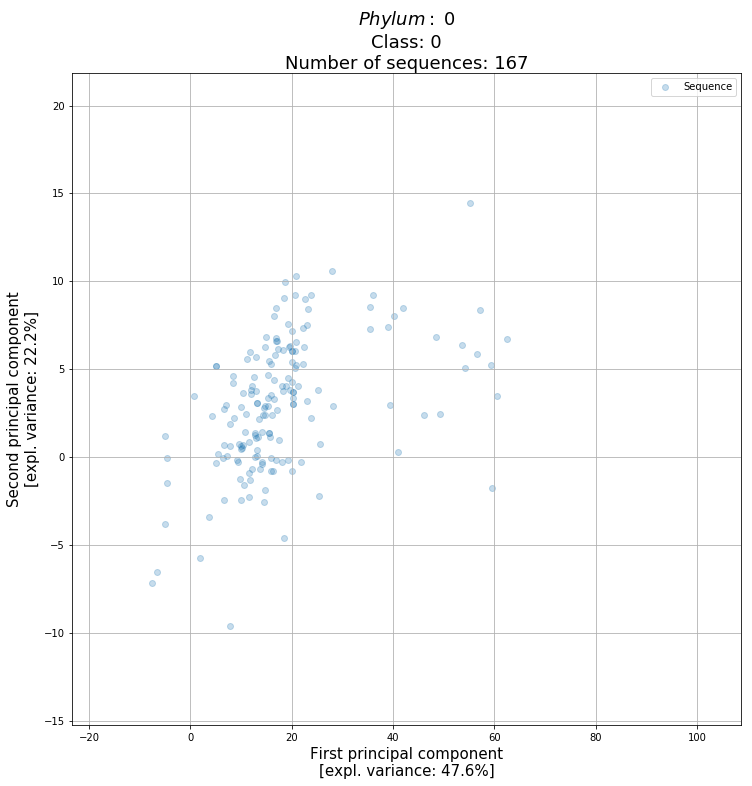

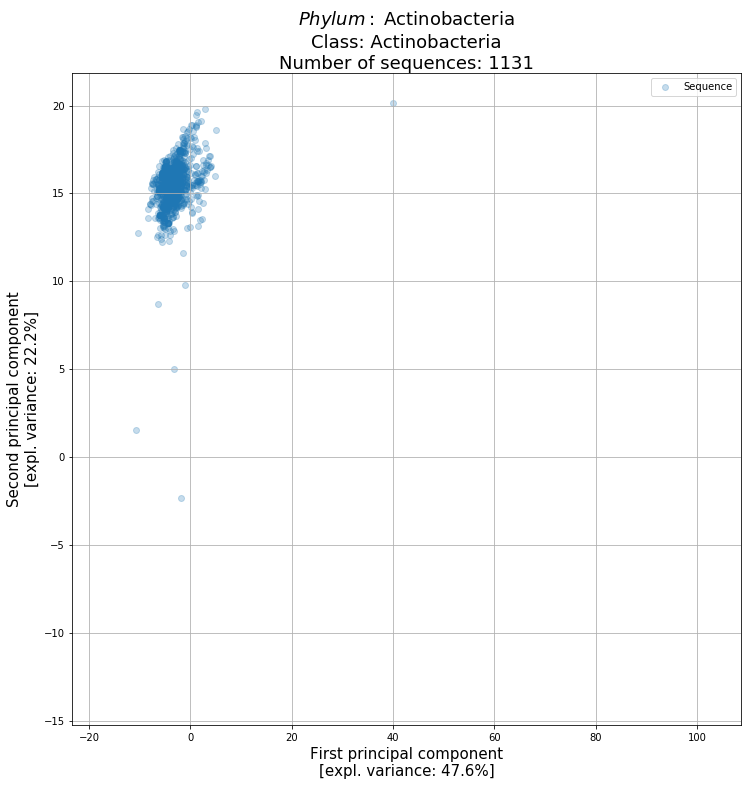

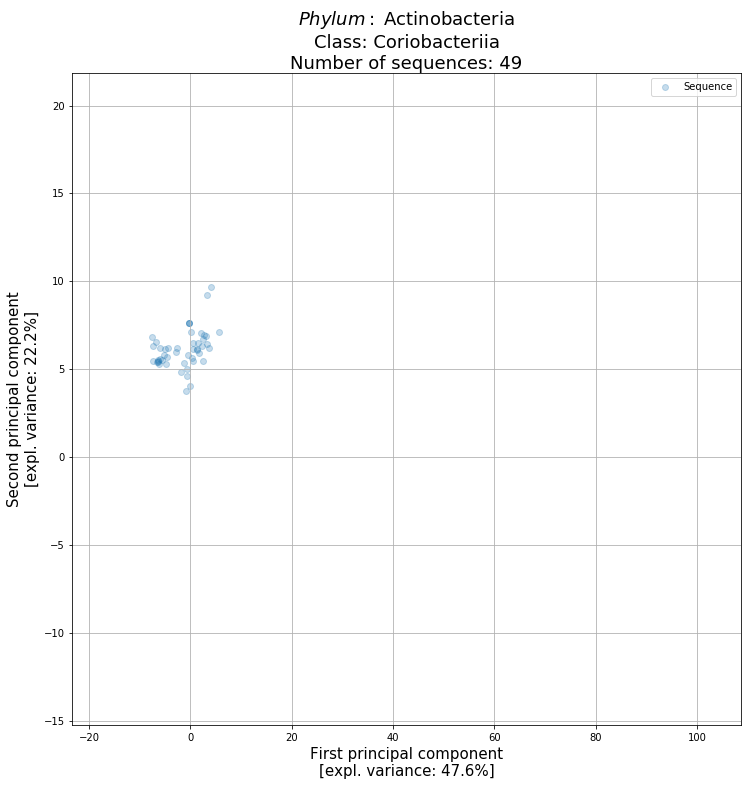

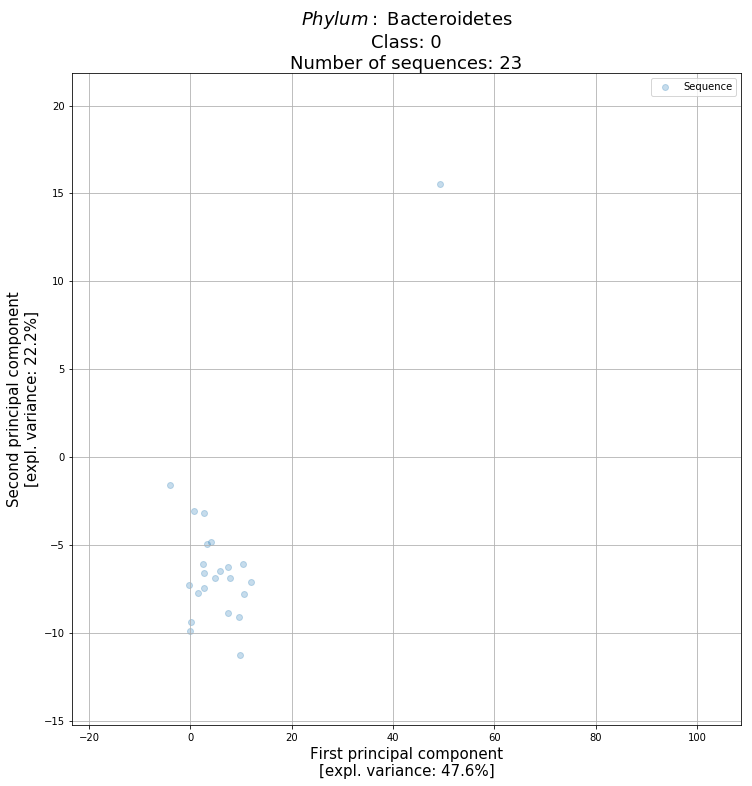

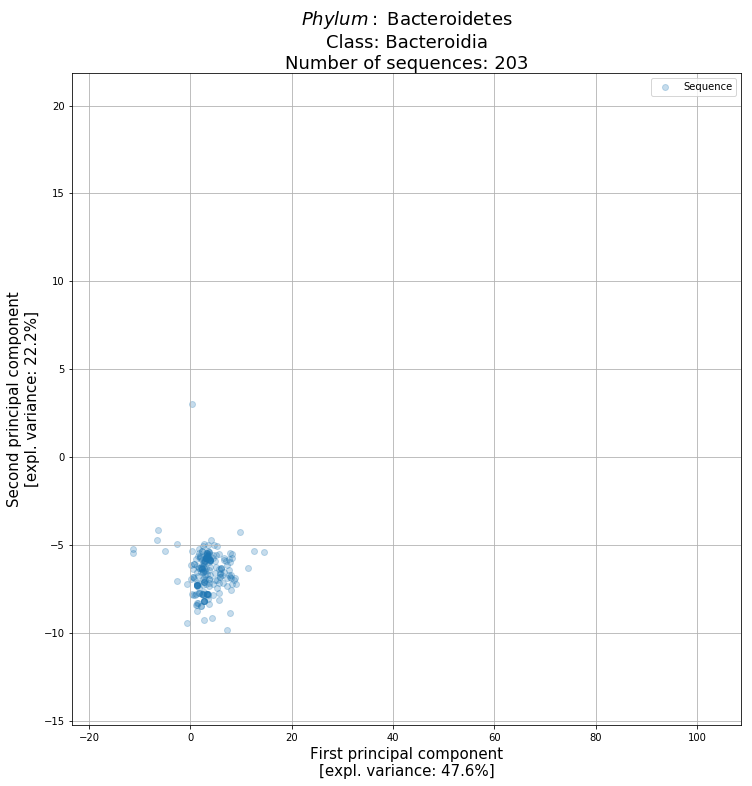

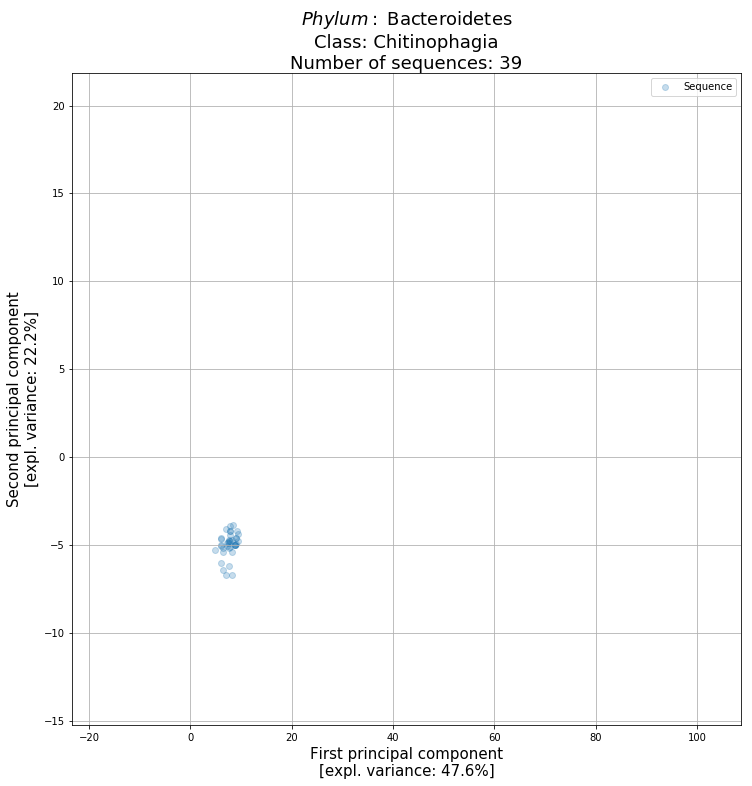

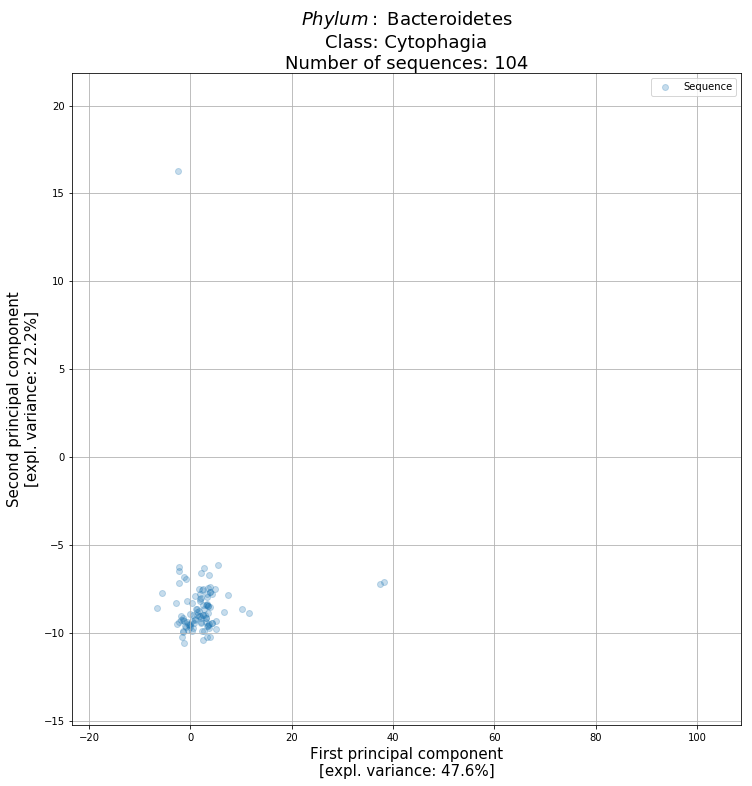

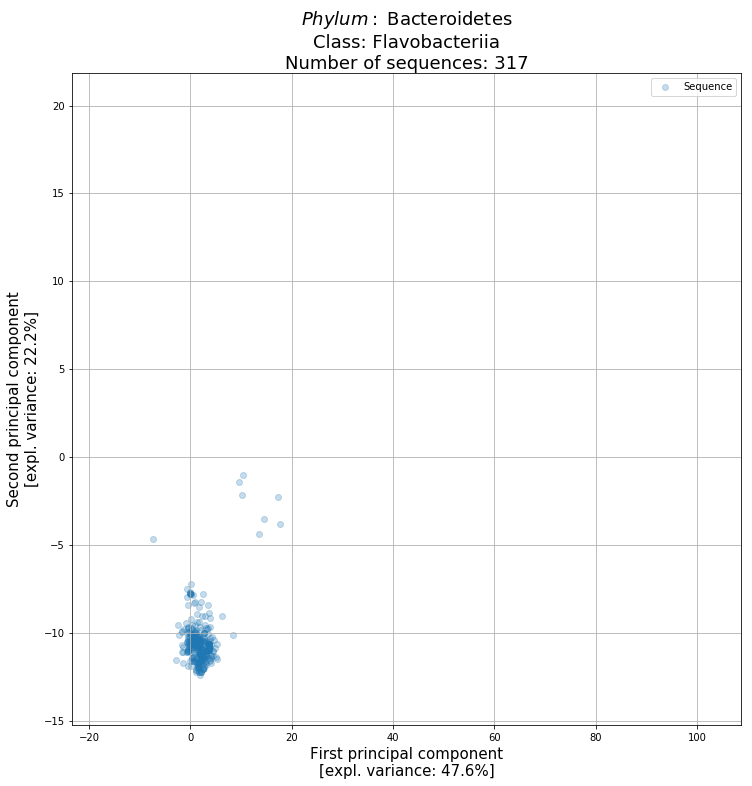

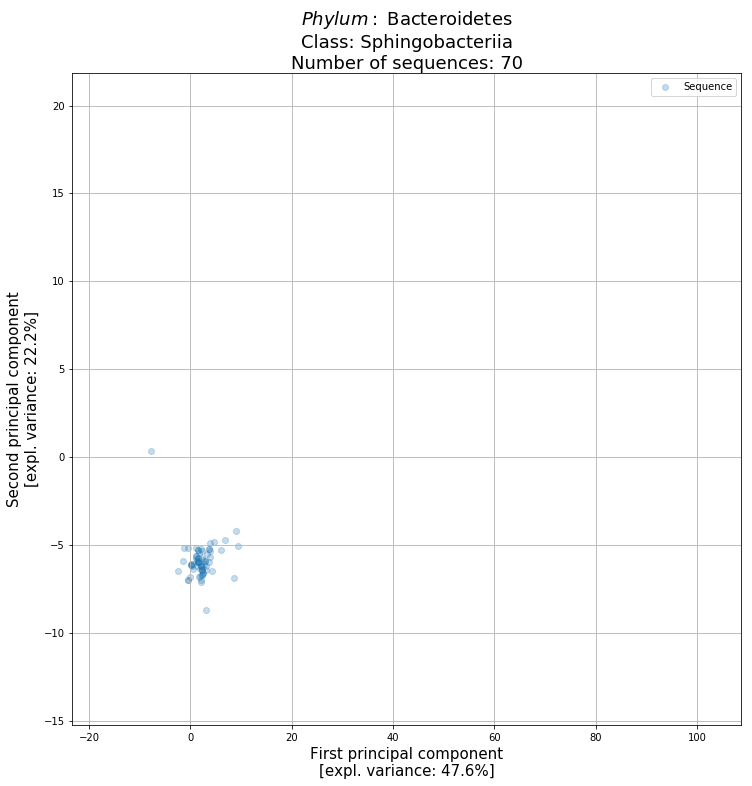

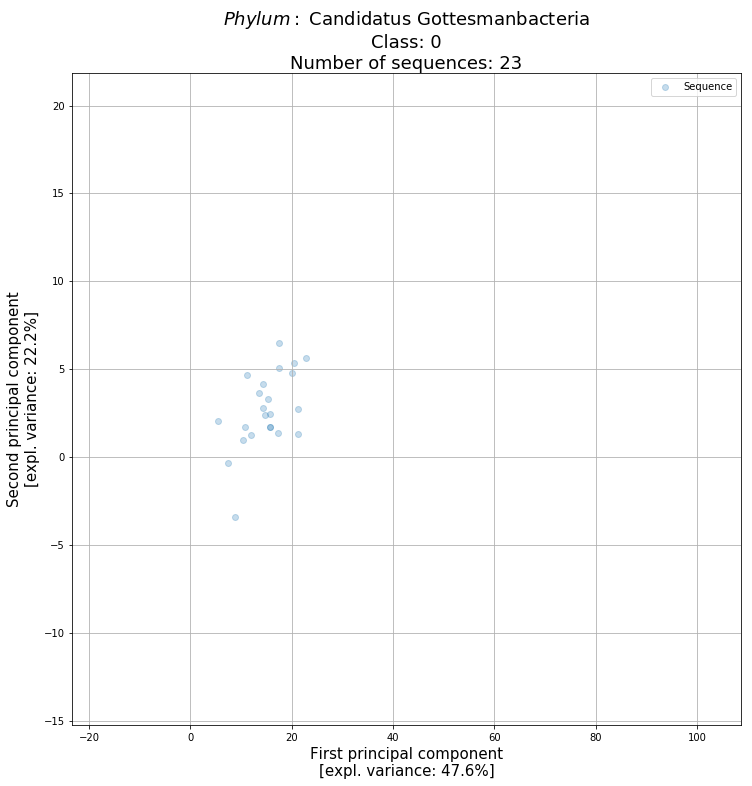

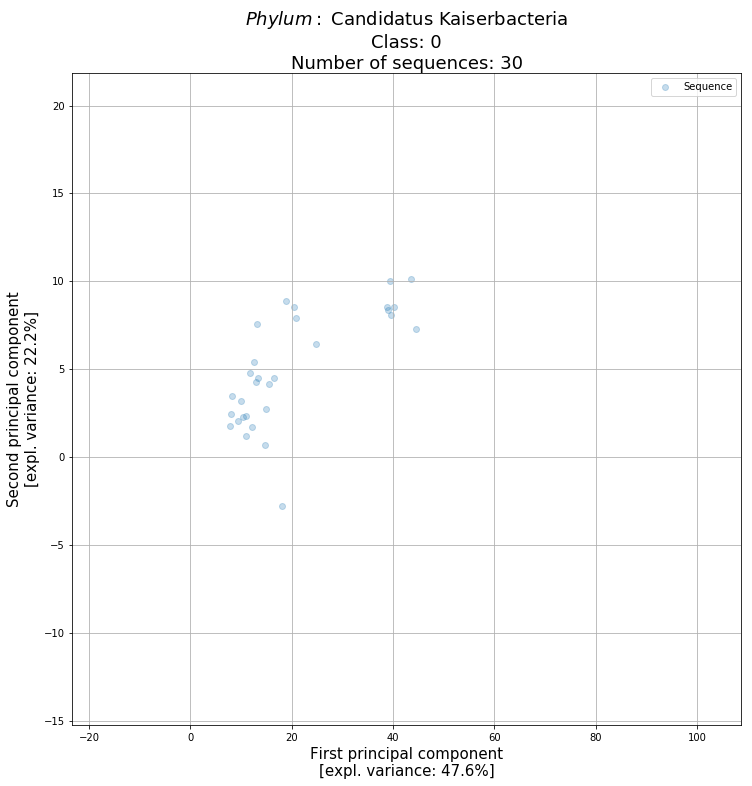

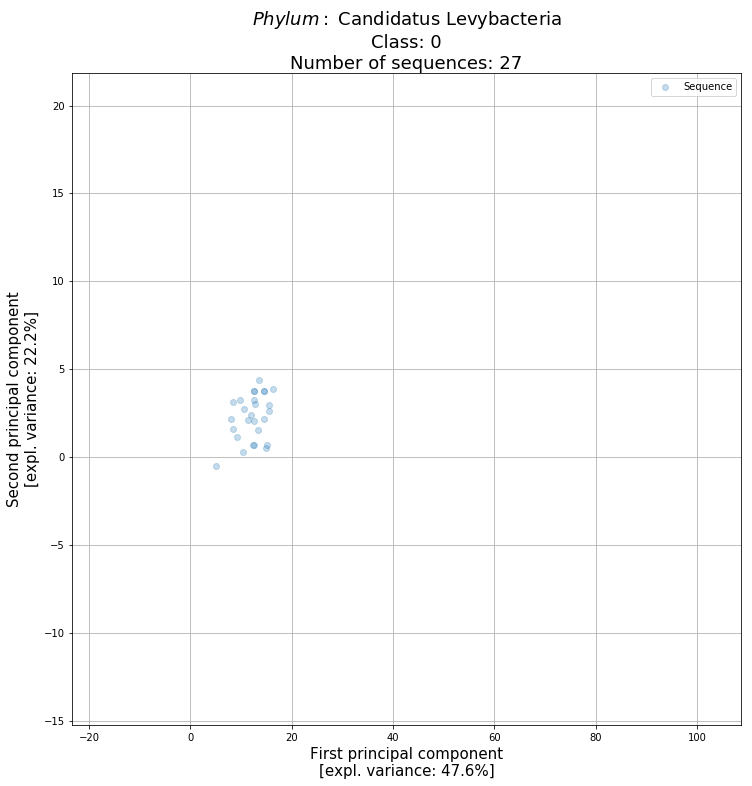

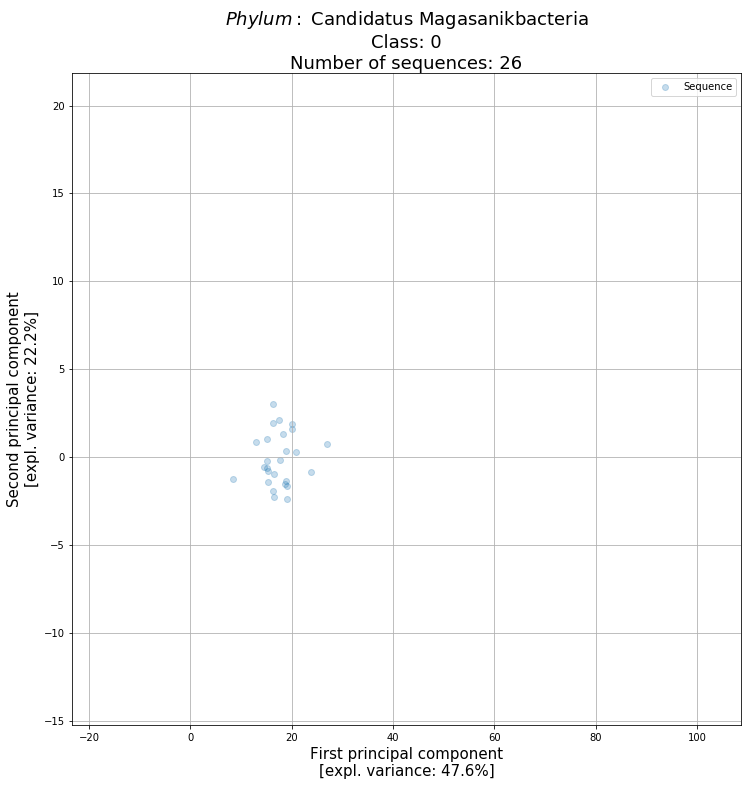

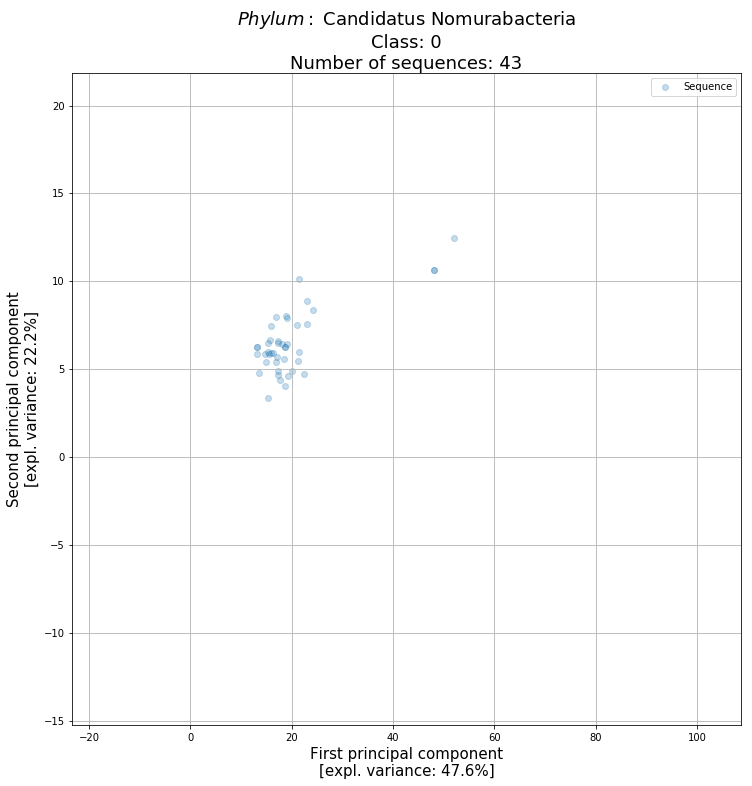

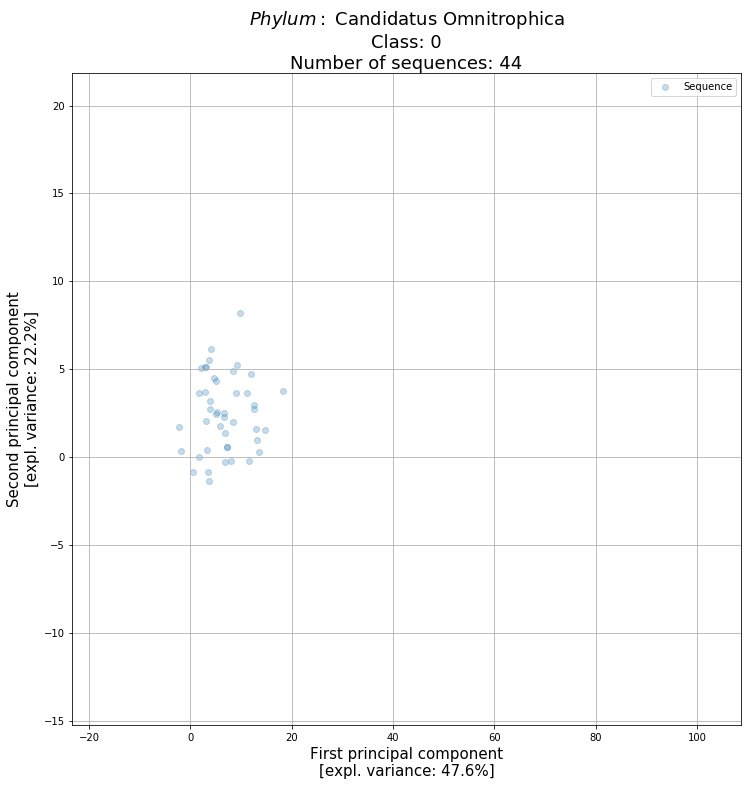

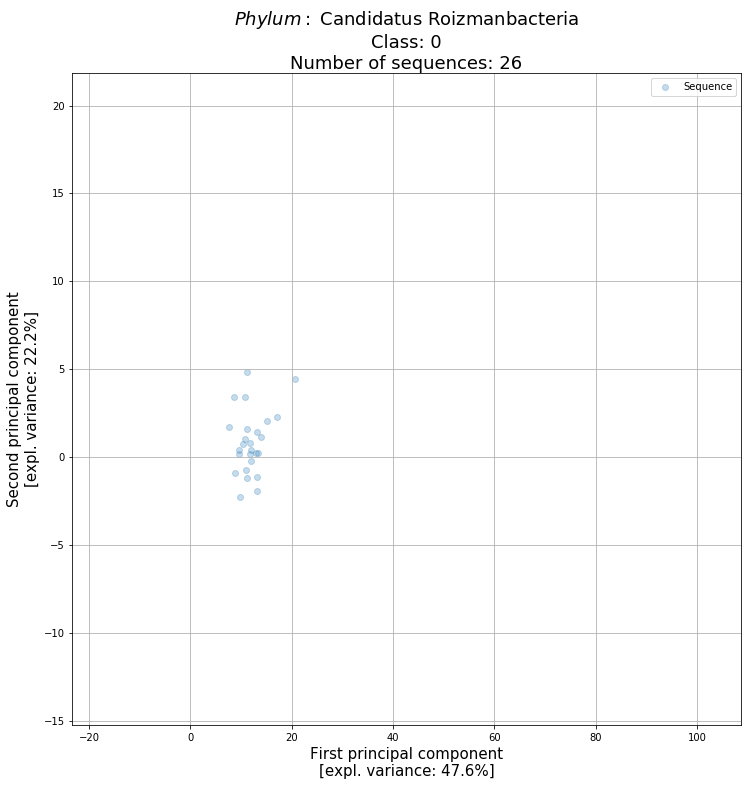

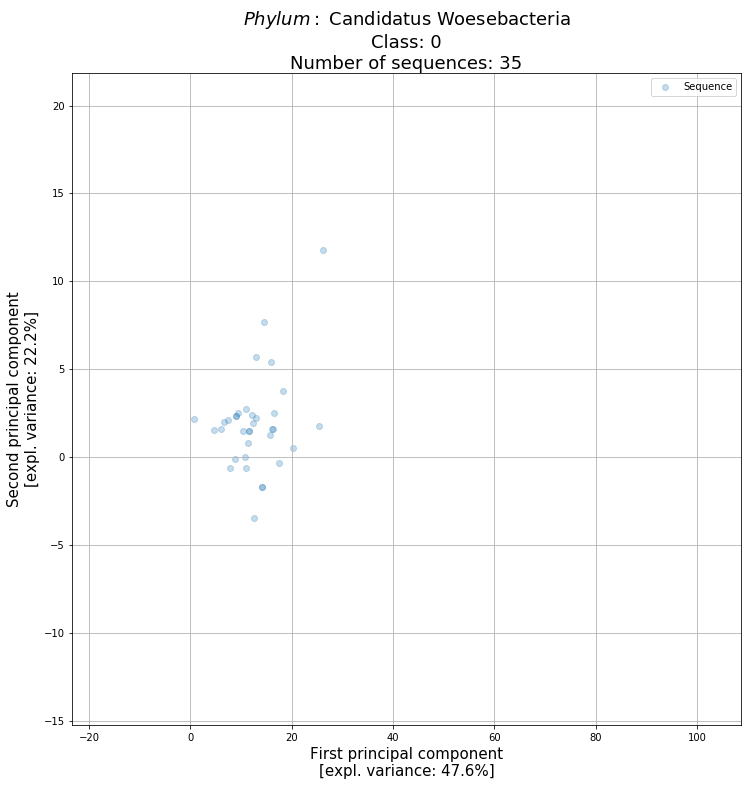

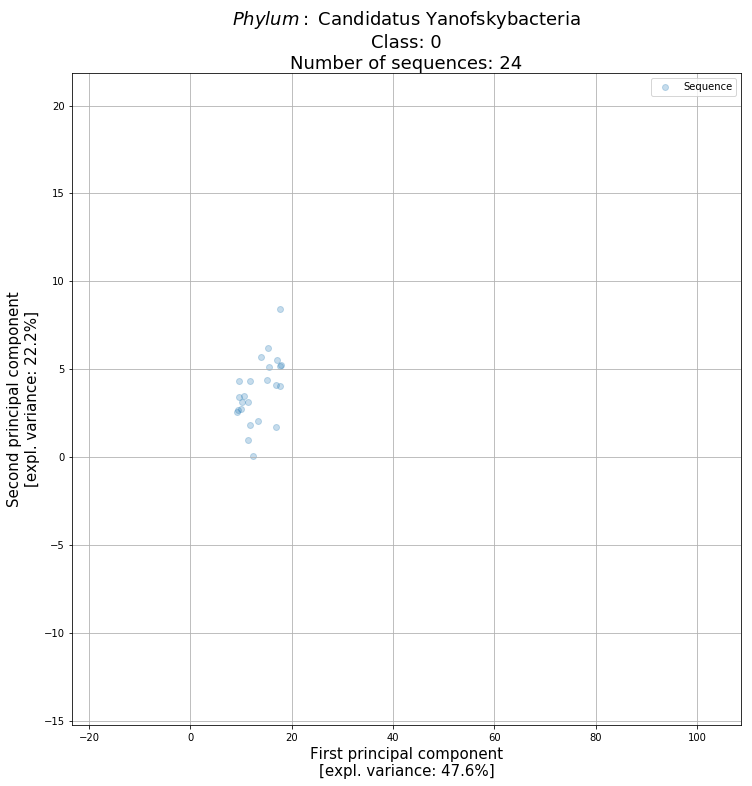

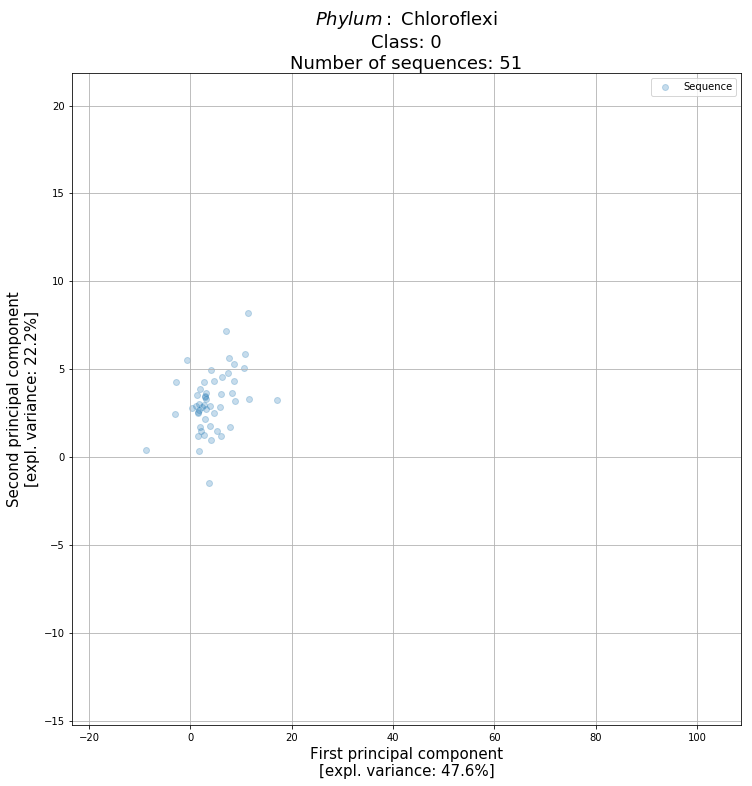

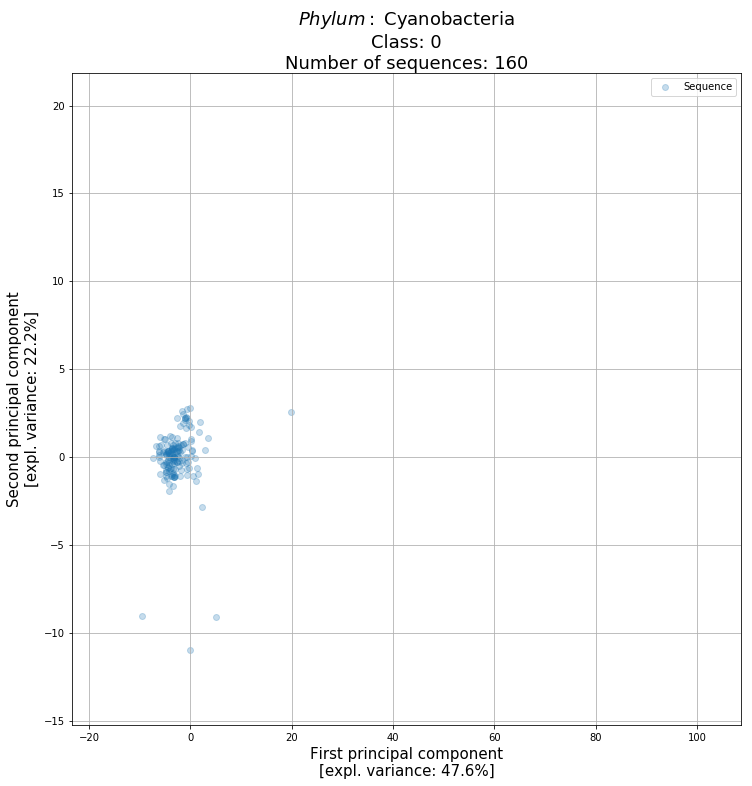

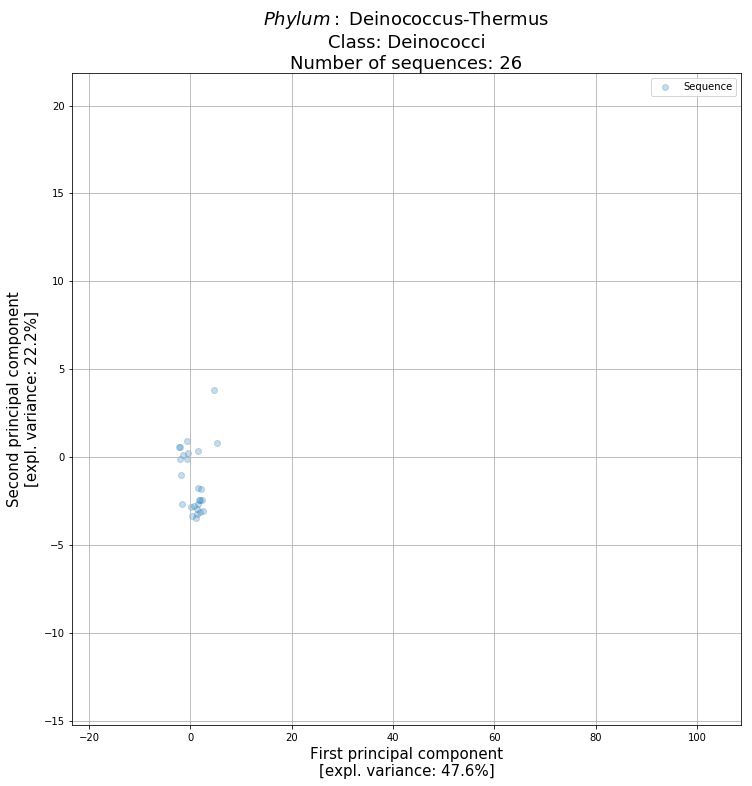

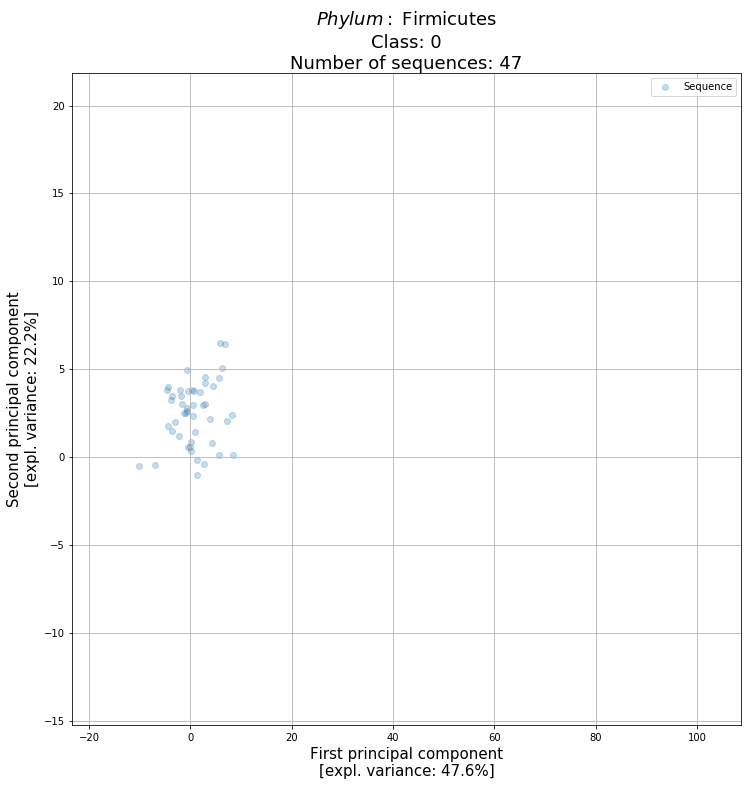

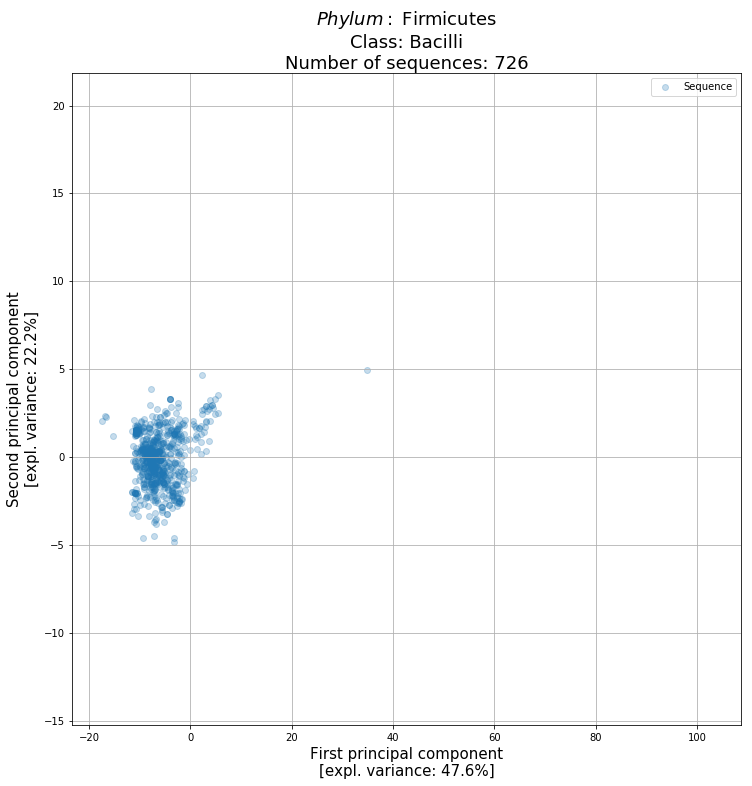

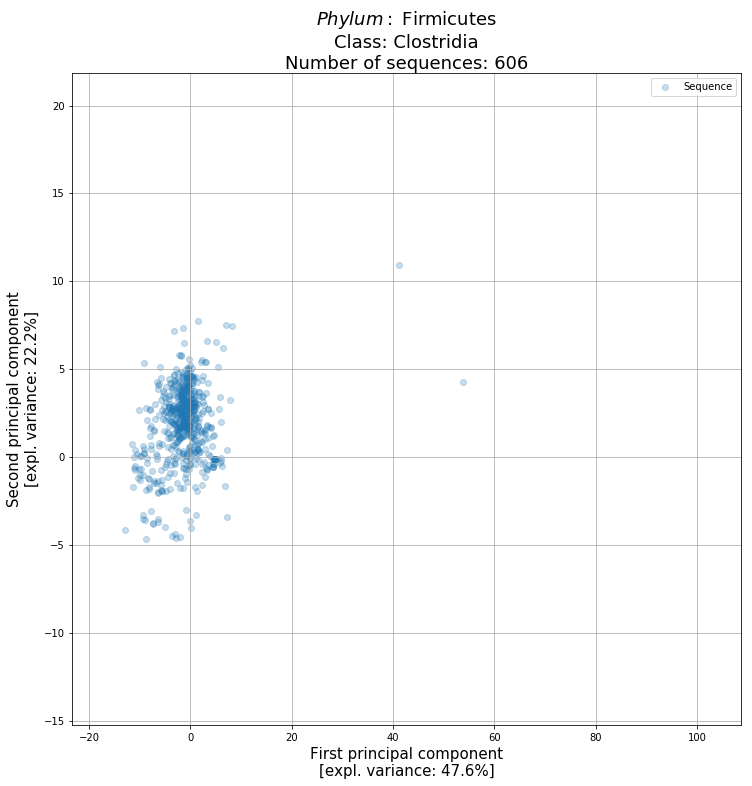

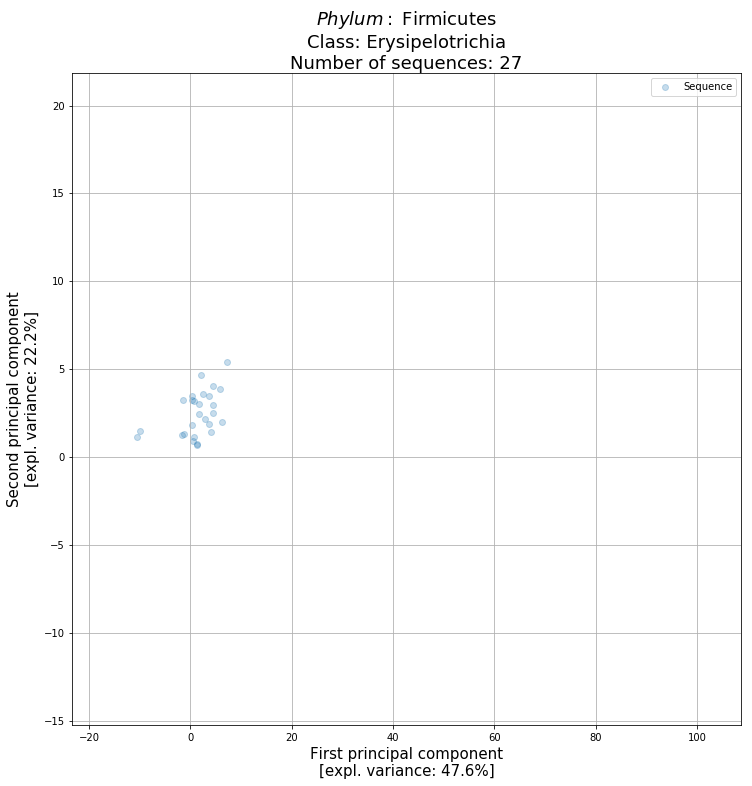

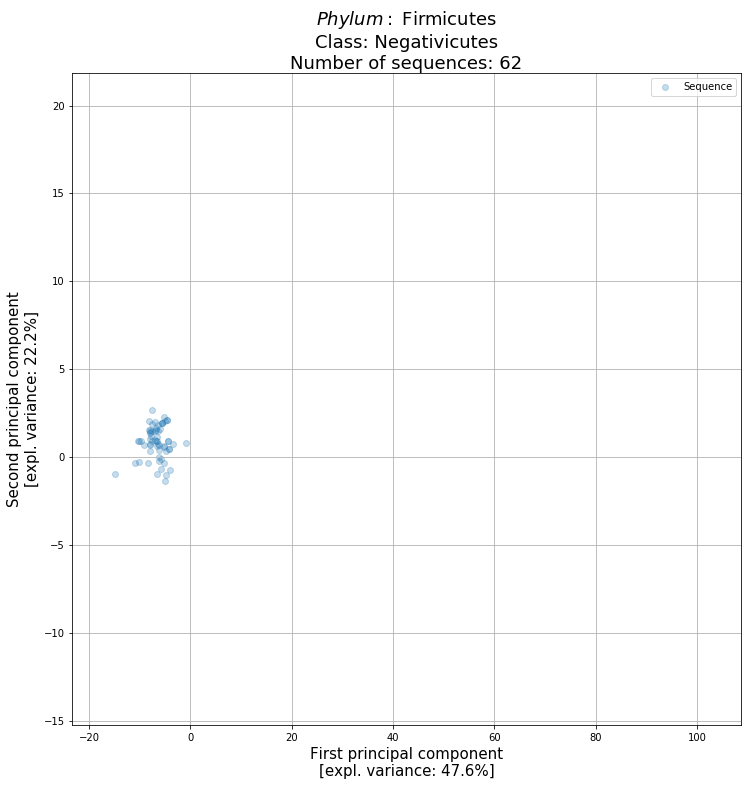

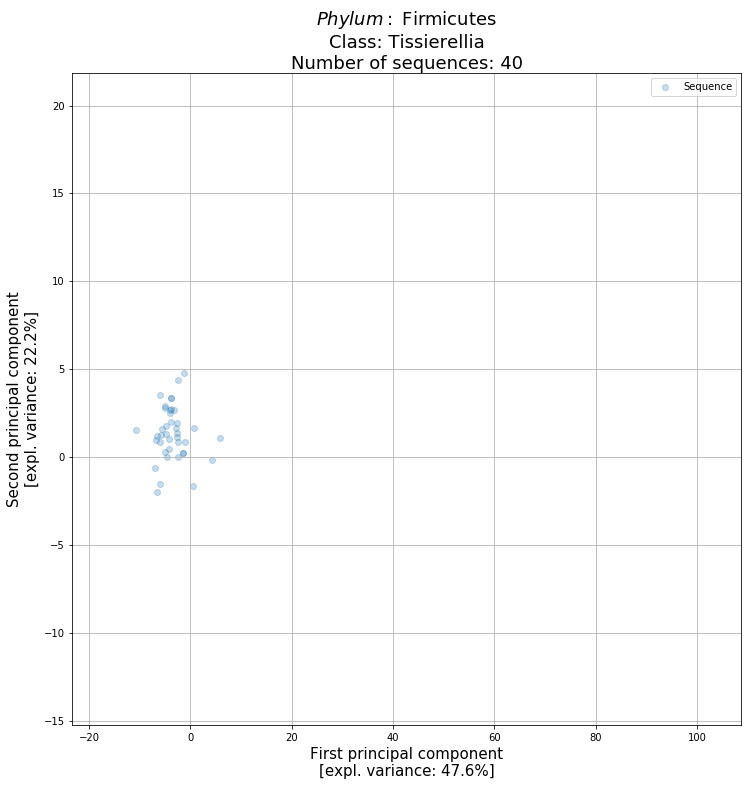

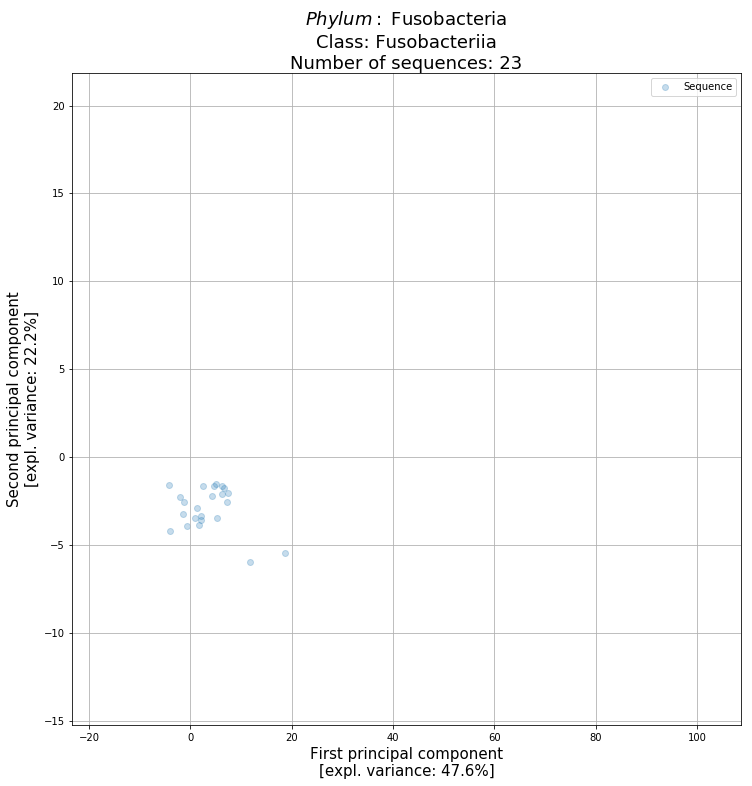

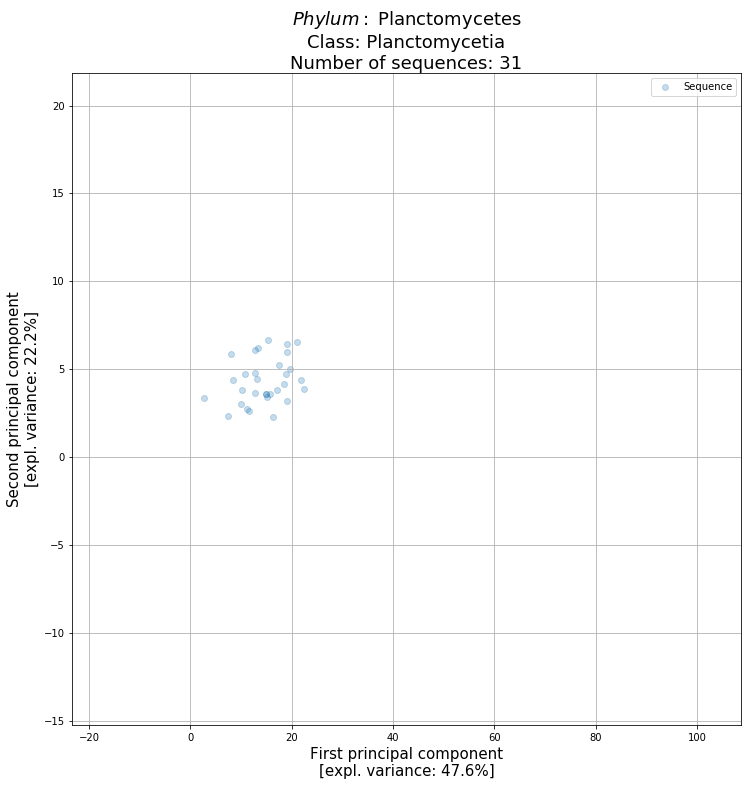

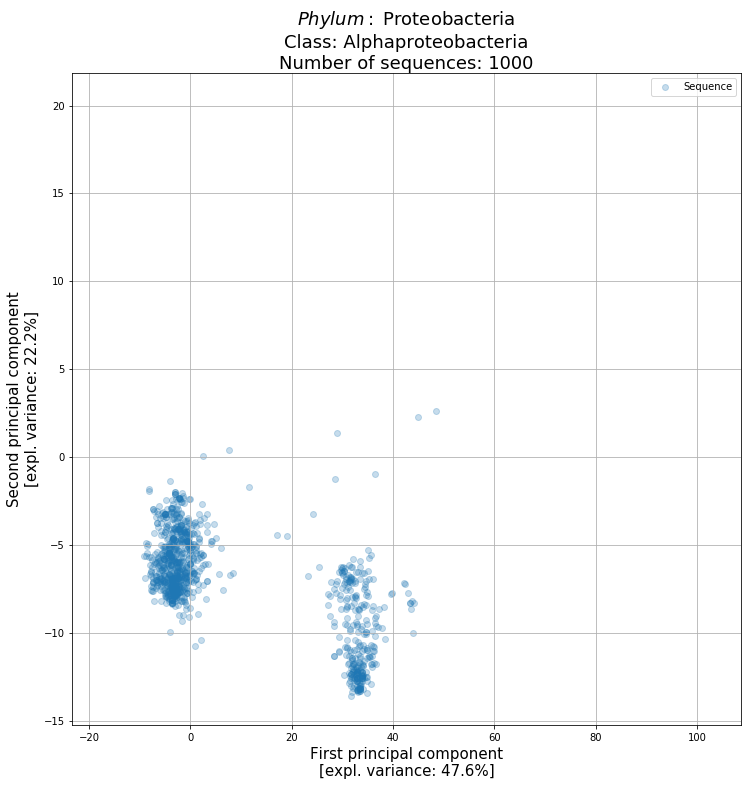

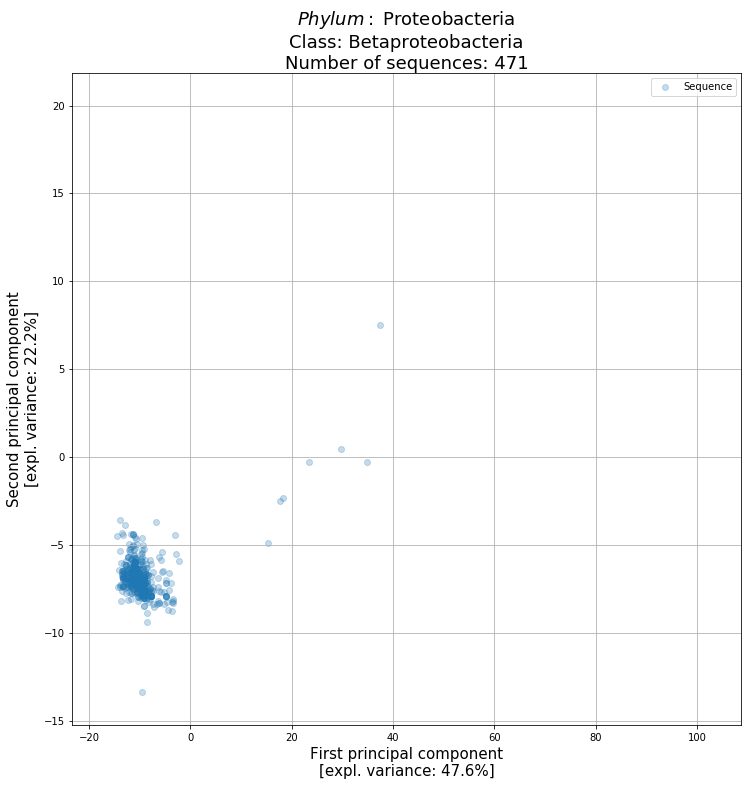

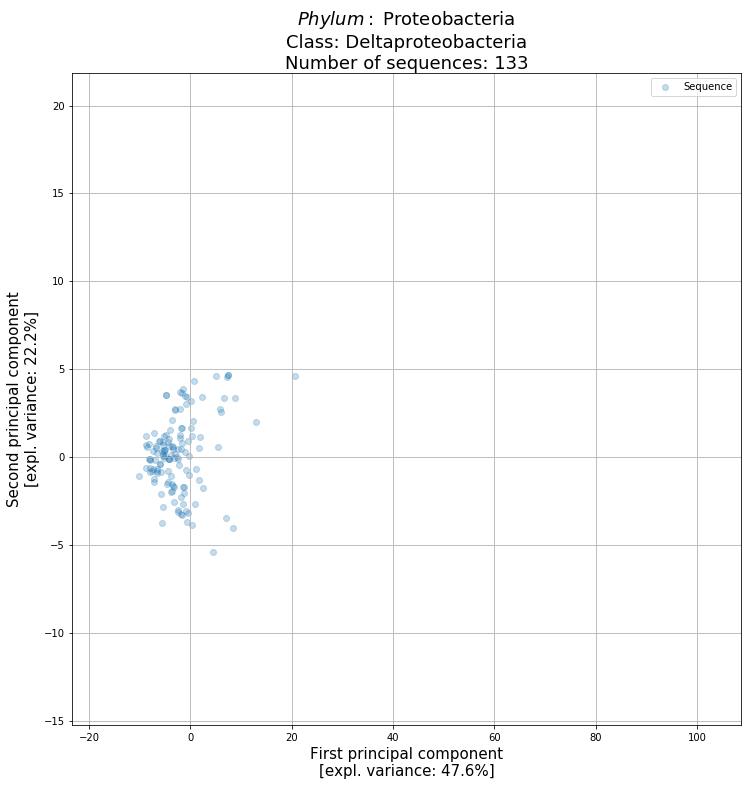

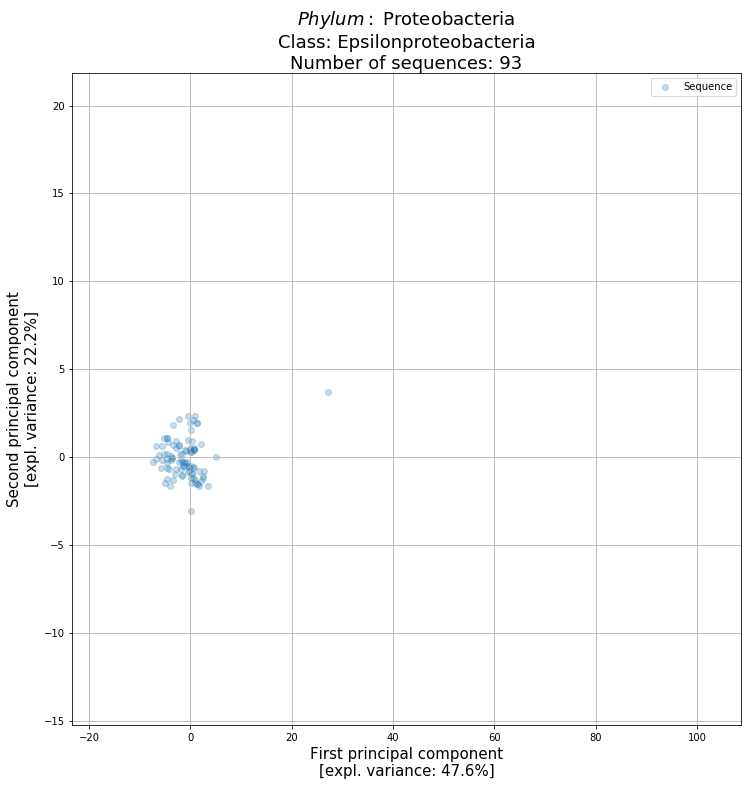

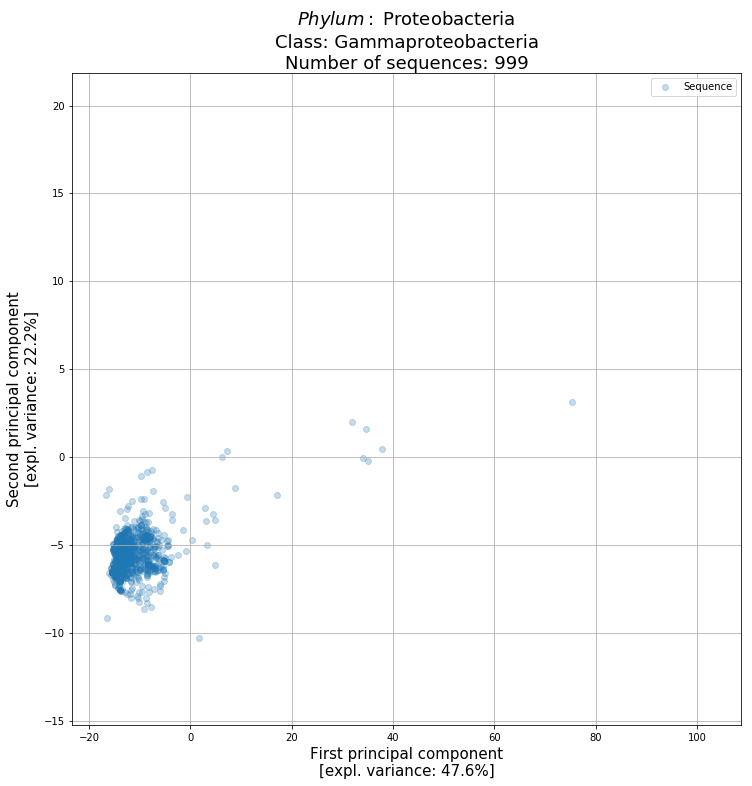

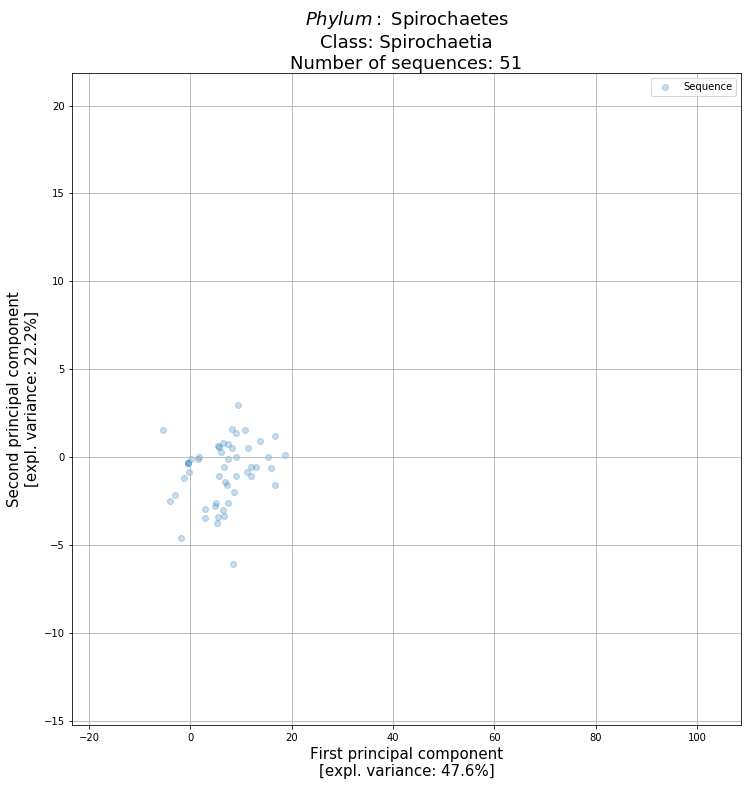

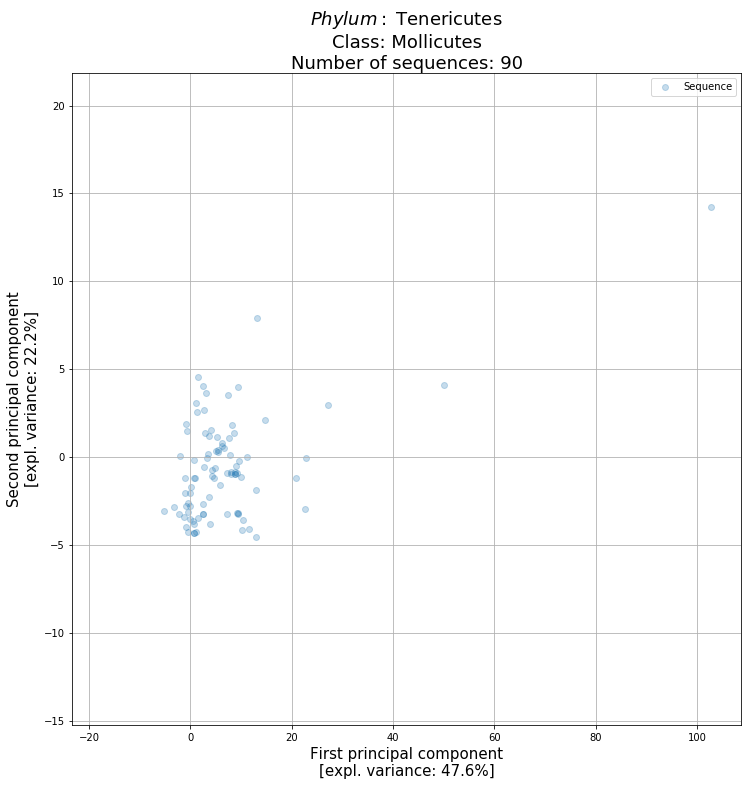

In [18]:
# plotting all plots of different triplets which have more than 10 points

for ambo,clust in zip(super_group2,cluster2):
    
    plot_data = data_final[clust]
    
    if len(plot_data)>20:
        plt.figure(figsize=(12,12))
        plt.grid()
        plt.xlabel('First principal component\n[expl. variance: ' 
              + str("{:.1f}".format(pca_function.explained_variance_ratio_[0]*100)) + '%]', fontsize = 15)
        plt.ylabel('Second principal component\n[expl. variance: '
              + str("{:.1f}".format(pca_function.explained_variance_ratio_[1]*100)) + '%]', fontsize = 15)
        plt.title(r'$Phylum:$ '+str(ambo[0])+'\nClass: '+str(ambo[1])+
                  '\nNumber of sequences: '+str(len(plot_data)), fontsize = 18)
        plt.scatter(plot_data[:,0],plot_data[:,1], alpha=0.25, label = 'Sequence')
        plt.legend()
        plt.ylim(boundy[0],boundy[1])
        plt.xlim(boundx[0],boundx[1])
        plt.show()


In the previous plots, the axes have always the same dimensions and limits: by looking at them one can notice that the _Phylum-Class_ representation of the data shows a very interesting "separation" between different classes.

A possible interpretation of this fact is that proteins developed in each organism belonging to the same _Phylum-class_ group are very similar to each other and "different" from those of other groups. This can (in a certain way) "confirm" the taxonomic classification done by biologists. 

We now plot each uninque triplet "Phylum, order, class" whose members are more than 10 (as to prevent overcrowding) as a standalone graph.

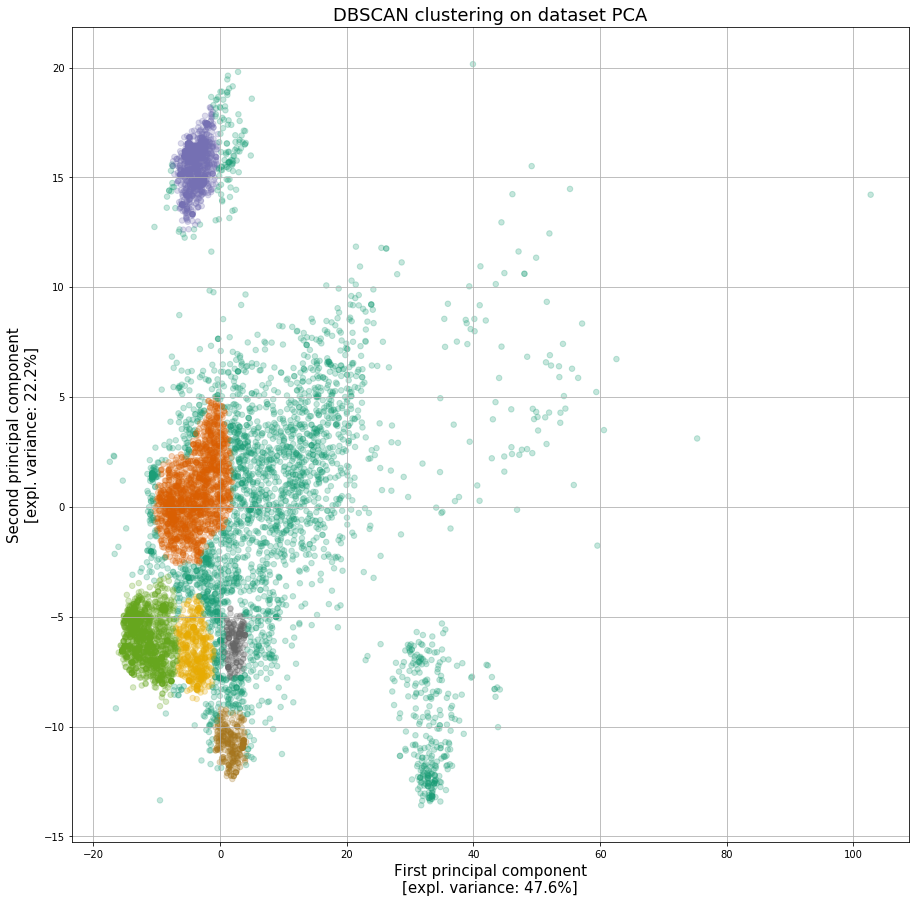

In [19]:
#unsupervised clustering, parameters to be chosen
db_func = DBSCAN(eps=1.1, min_samples=90).fit(data_final[:,0:2])
db_cluster=db_func.fit_predict(data_final[:,0:2])
plt.figure(figsize=(15,15))
plt.scatter(data_final[:,0], data_final[:,1], c=db_cluster, cmap="Dark2", s=30, marker="o",alpha=0.25)
plt.title(r"DBSCAN clustering on dataset PCA", fontsize=18)
plt.xlabel('First principal component\n[expl. variance: ' 
              + str("{:.1f}".format(pca_function.explained_variance_ratio_[0]*100)) + '%]', fontsize = 15)
plt.ylabel('Second principal component\n[expl. variance: '
              + str("{:.1f}".format(pca_function.explained_variance_ratio_[1]*100)) + '%]', fontsize = 15)
plt.grid()

plt.show()

Now we plot, adding one by one, all the first 8 biggest classes (without considering the _phylum_ classification) to see if they form "significative" groups.

(Remark: we can plot only classes because we first verified that class names are unique even between different _phyla_)

As shown above, the class-based plots have some clustered distribution.

Now, we perform a _Phyla_-based "clustering", meaning that we plot all _Phyla_ on the same graph. Hopefully, the clusters they form should approximately mirror the ones in the graph above.

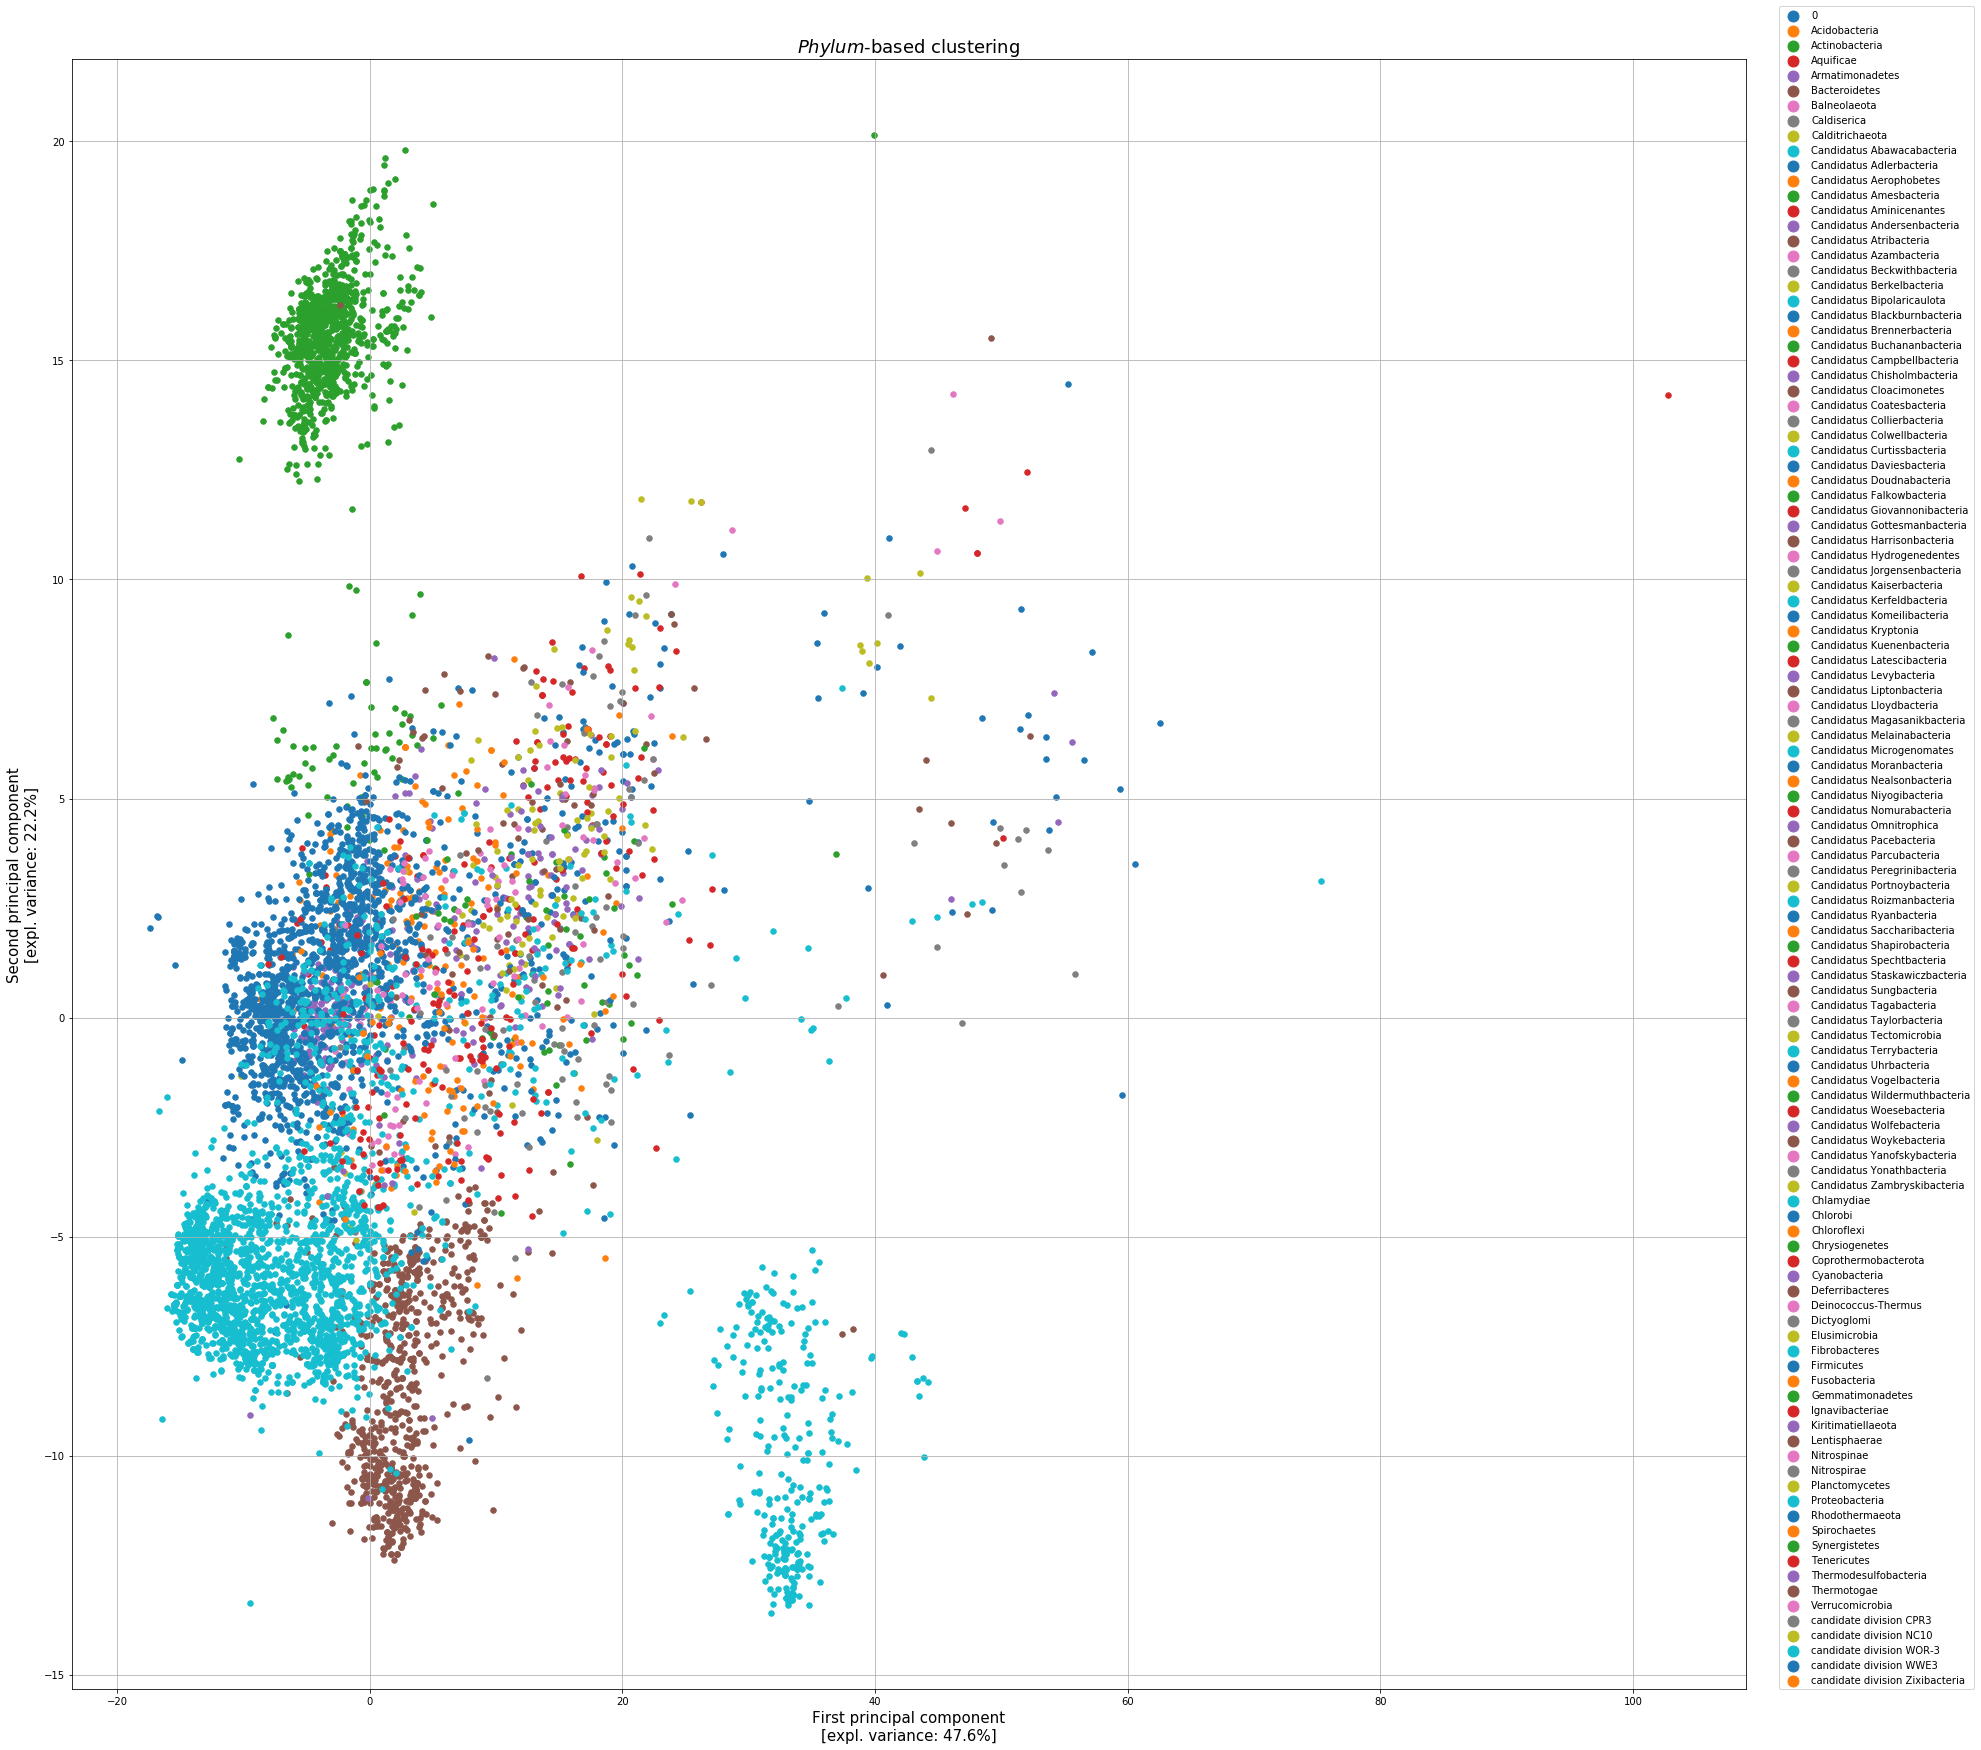

In [20]:
plt.figure(figsize=(30,30))
plt.title(r'$Phylum$-based clustering',fontsize = 18)
plt.xlabel('First principal component\n[expl. variance: ' 
              + str("{:.1f}".format(pca_function.explained_variance_ratio_[0]*100)) + '%]', fontsize = 15)
plt.ylabel('Second principal component\n[expl. variance: '
              + str("{:.1f}".format(pca_function.explained_variance_ratio_[1]*100)) + '%]', fontsize = 15)

for phy in np.unique(pd.DataFrame(final)['phylum']):
    data_plot = pd.DataFrame(final).index[pd.DataFrame(final)['phylum']==phy].tolist()
    plt.scatter(data_final[data_plot,0],data_final[data_plot,1], label = phy, s=30)

plt.legend(loc=(1.02,0), ncol=1, borderaxespad=0., markerscale=2)
plt.grid()
plt.show()

The sheer number of possible _Phyla_ clusters makes this kind of comparison rather pointless. The next step in our analysis aims to avoid this problem.

## PCA on the trimmed dataset

<a id='Return-from-phyla-graph'></a>
As already mentioned, we can use the power-law behaviour of the dataset with respect to _Phylum_-based grouping to ignore the sequences belonging to the "smaller" _Phyla_.

We therefore:
 - fixed an arbitrary threshold, which represents the fraction of the dataset to which we want to restrict our analysis to;
 - we removed the whole '0' _Phylum_, as it essentially is an unclassified set of sequences, and thus it is non-informative.

Utility for the trimming of the dataset follows.

In [21]:
#creating the lists of phyla numbers of members and phyla names
phy_len_sort = np.array([distribution_phy[1][i] for i in range(len(distribution_phy[1]))])
phy_name_sort = np.array([distribution_phy[0][i] for i in range(len(distribution_phy[1]))])
df = []
for (name,phy) in zip(phy_name_sort,phy_len_sort):
    df.append([name,phy])
    
pd.DataFrame(np.array(df), columns=('Phylum','Number_of_members'))

Phylum Number_of_members
0                     Proteobacteria              2747
1                         Firmicutes              1509
2                     Actinobacteria              1190
3                      Bacteroidetes               764
4                                  0               167
5                      Cyanobacteria               162
6                        Tenericutes                93
7                        Chloroflexi                90
8                       Spirochaetes                55
9            Candidatus Omnitrophica                44
10         Candidatus Nomurabacteria                43
11                    Planctomycetes                42
12          Candidatus Woesebacteria                35
13         Candidatus Kaiserbacteria                30
14                   Verrucomicrobia                29
15           Candidatus Levybacteria                27
16        Candidatus Roizmanbacteria                26
17      Candidatus Magasanikbacteria                26
18               Deinococcus-Thermus                26
19       Candidatus Yanofskybacteria                24
20      Candidatus Gottesmanbacteria                23
21                      Fusobacteria                23
22      Candidatus Peregrinibacteria                20
23                        Chlamydiae                19
24                   Ignavibacteriae                19
25          Candidatus Parcubacteria                18
26                          Chlorobi                17
27                         Aquificae                17
28            Candidatus Uhrbacteria                17
29                     Acidobacteria                17
..                               ...               ...
82         Candidatus Kuenenbacteria                 3
83        Candidatus Kerfeldbacteria                 3
84       Candidatus Chisholmbacteria                 3
85           candidate division NC10                 3
86                      Balneolaeota                 3
87                       Nitrospinae                 2
88                Kiritimatiellaeota                 2
89   candidate division Zixibacteria                 2
90         Candidatus Niyogibacteria                 2
91        Candidatus Hydrogenedentes                 2
92       Candidatus Andersenbacteria                 2
93          Candidatus Tectomicrobia                 2
94           Candidatus Tagabacteria                 2
95         Candidatus Berkelbacteria                 2
96      Candidatus Blackburnbacteria                 2
97           Candidatus Aerophobetes                 1
98         Candidatus Doudnabacteria                 1
99          candidate division WOR-3                 1
100          candidate division CPR3                 1
101             Candidatus Kryptonia                 1
102       Candidatus Latescibacteria                 1
103       Candidatus Bipolaricaulota                 1
104       Candidatus Brennerbacteria                 1
105                      Dictyoglomi                 1
106                      Caldiserica                 1
107                  Calditrichaeota                 1
108                   Chrysiogenetes                 1
109       Candidatus Abawacabacteria                 1
110             Coprothermobacterota                 1
111        Candidatus Coatesbacteria                 1

[112 rows x 2 columns]

We decided to first remove the '0' _phylum_, as it was deemed non-informative. Then, we fixed an arbitrary ratio of the dataset (with the '0' removed) to keep; the fraction of sequences to be eliminated were chosen from the smaller _phyla_. The result of this procedure is that a small decrease in the number of sequences was traded for a great reduction in the number of _phyla_ in the dataset, thus leading to more informative taxonomic clustering.

In [22]:
#removing the 0 phylum from the dataset

for i_phy in range(len(phy_name_sort)-1):
    if phy_name_sort[i_phy]=='0':
        phy_name_sort = np.delete(phy_name_sort, i_phy)
        phy_len_sort = np.delete(phy_len_sort, i_phy)
        
indexes_to_keep = final.index[final['phylum']!='0'].tolist()

In [23]:
def iterFlatten(root):
    if isinstance(root, (list, tuple)):
        for element in root:
            for e in iterFlatten(element):
                yield e
    else:
        yield root

In [24]:
#removing the 0s
clean_data = data_cantor[indexes_to_keep]
clean_data = clean_data[:,indexes_to_keep]

#an arbitrarily chosen ratio
thresh = 0.9 
L = len(clean_data)

i=1
while np.sum(phy_len_sort[:i])<thresh*L:
    i+=1
    
phy_len_thresh = phy_len_sort[:i]
phy_name_thresh = phy_name_sort[:i]

#list of indexes corresponding to the phyla to keep
selection_90 = []
for name in phy_name_thresh:
    selection_90.append(final.index[final["phylum"]==name].tolist())
    
indexes_trimmed=list(iterFlatten(selection_90))

Before repeating the PCA on the trimmed dataset, we once again plotted the _phylum_ based clustering on the previous PCA, this time showing only the numerically relevant _phyla_.

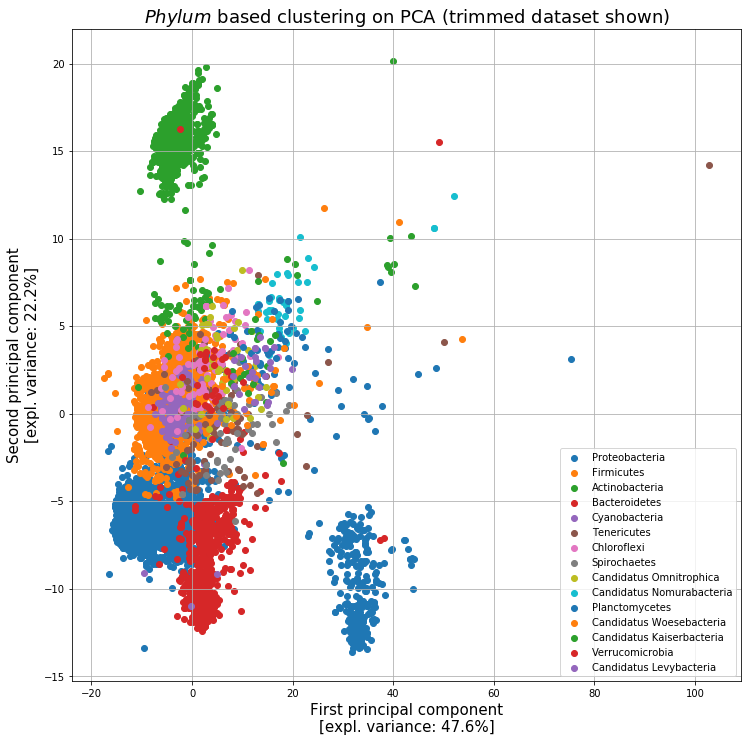

In [25]:
plt.figure(figsize=(12,12))
for phy in selection_90:
    data_plot = data_final[phy]
    plt.scatter(data_plot[:,0], data_plot[:,1], label=phy_name_thresh[selection_90.index(phy)], alpha=0.25)
    
plt.title(r"$Phylum$ based clustering on PCA (trimmed dataset shown)", fontsize=18)
plt.xlabel('First principal component\n[expl. variance: ' 
              + str("{:.1f}".format(pca_function.explained_variance_ratio_[0]*100)) + '%]', fontsize = 15)
plt.ylabel('Second principal component\n[expl. variance: '
              + str("{:.1f}".format(pca_function.explained_variance_ratio_[1]*100)) + '%]', fontsize = 15)
plt.grid()
plt.legend()
plt.show()

The blue clusters corresponds only to Protebacteria (as one can verify looking at the "single phylum" plots)

# New PCA on trimmed data

Here the PCA is performed on the trimmed dataset.

In [26]:
pca_function2 = PCA(n_components=2)

# evaluating pca
#data_projected_clean = pca_function2.fit_transform(clean_data)

# "trick" such that the list "indeces to keep" is still valid: building a matrix 7786,2 such that the projected data fit well in it
data_projected_clean = np.zeros((7786, 2))
data_projected_clean[indexes_trimmed] = pca_function2.fit_transform(data_cantor[indexes_trimmed][:,indexes_trimmed])
print(len(data_projected_clean))

7786


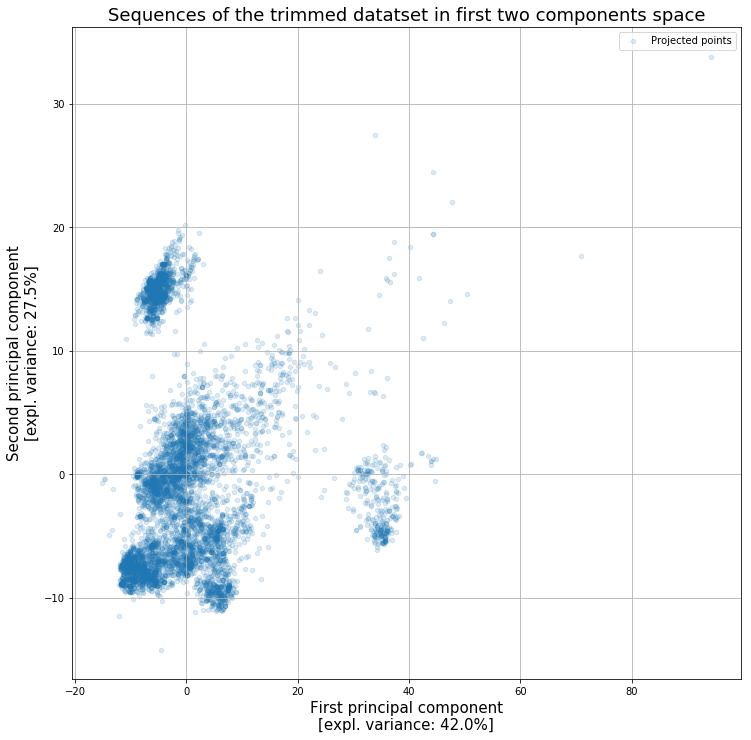

In [27]:
fig, ax = plt.subplots(figsize = (12, 12))
plt.scatter(data_projected_clean[:,0], data_projected_clean[:,1], alpha=0.15, s=20, label='Projected points')

ax.set_title('Sequences of the trimmed datatset in first two components space', fontsize = 18)
ax.set_xlabel('First principal component\n[expl. variance: ' 
              + str("{:.1f}".format(pca_function2.explained_variance_ratio_[0]*100)) + '%]', fontsize = 15)
ax.set_ylabel('Second principal component\n[expl. variance: '
              + str("{:.1f}".format(pca_function2.explained_variance_ratio_[1]*100)) + '%]', fontsize = 15)
boundx=ax.get_xbound()
boundy=ax.get_ybound()
ax.grid(True)
plt.legend()
plt.show()

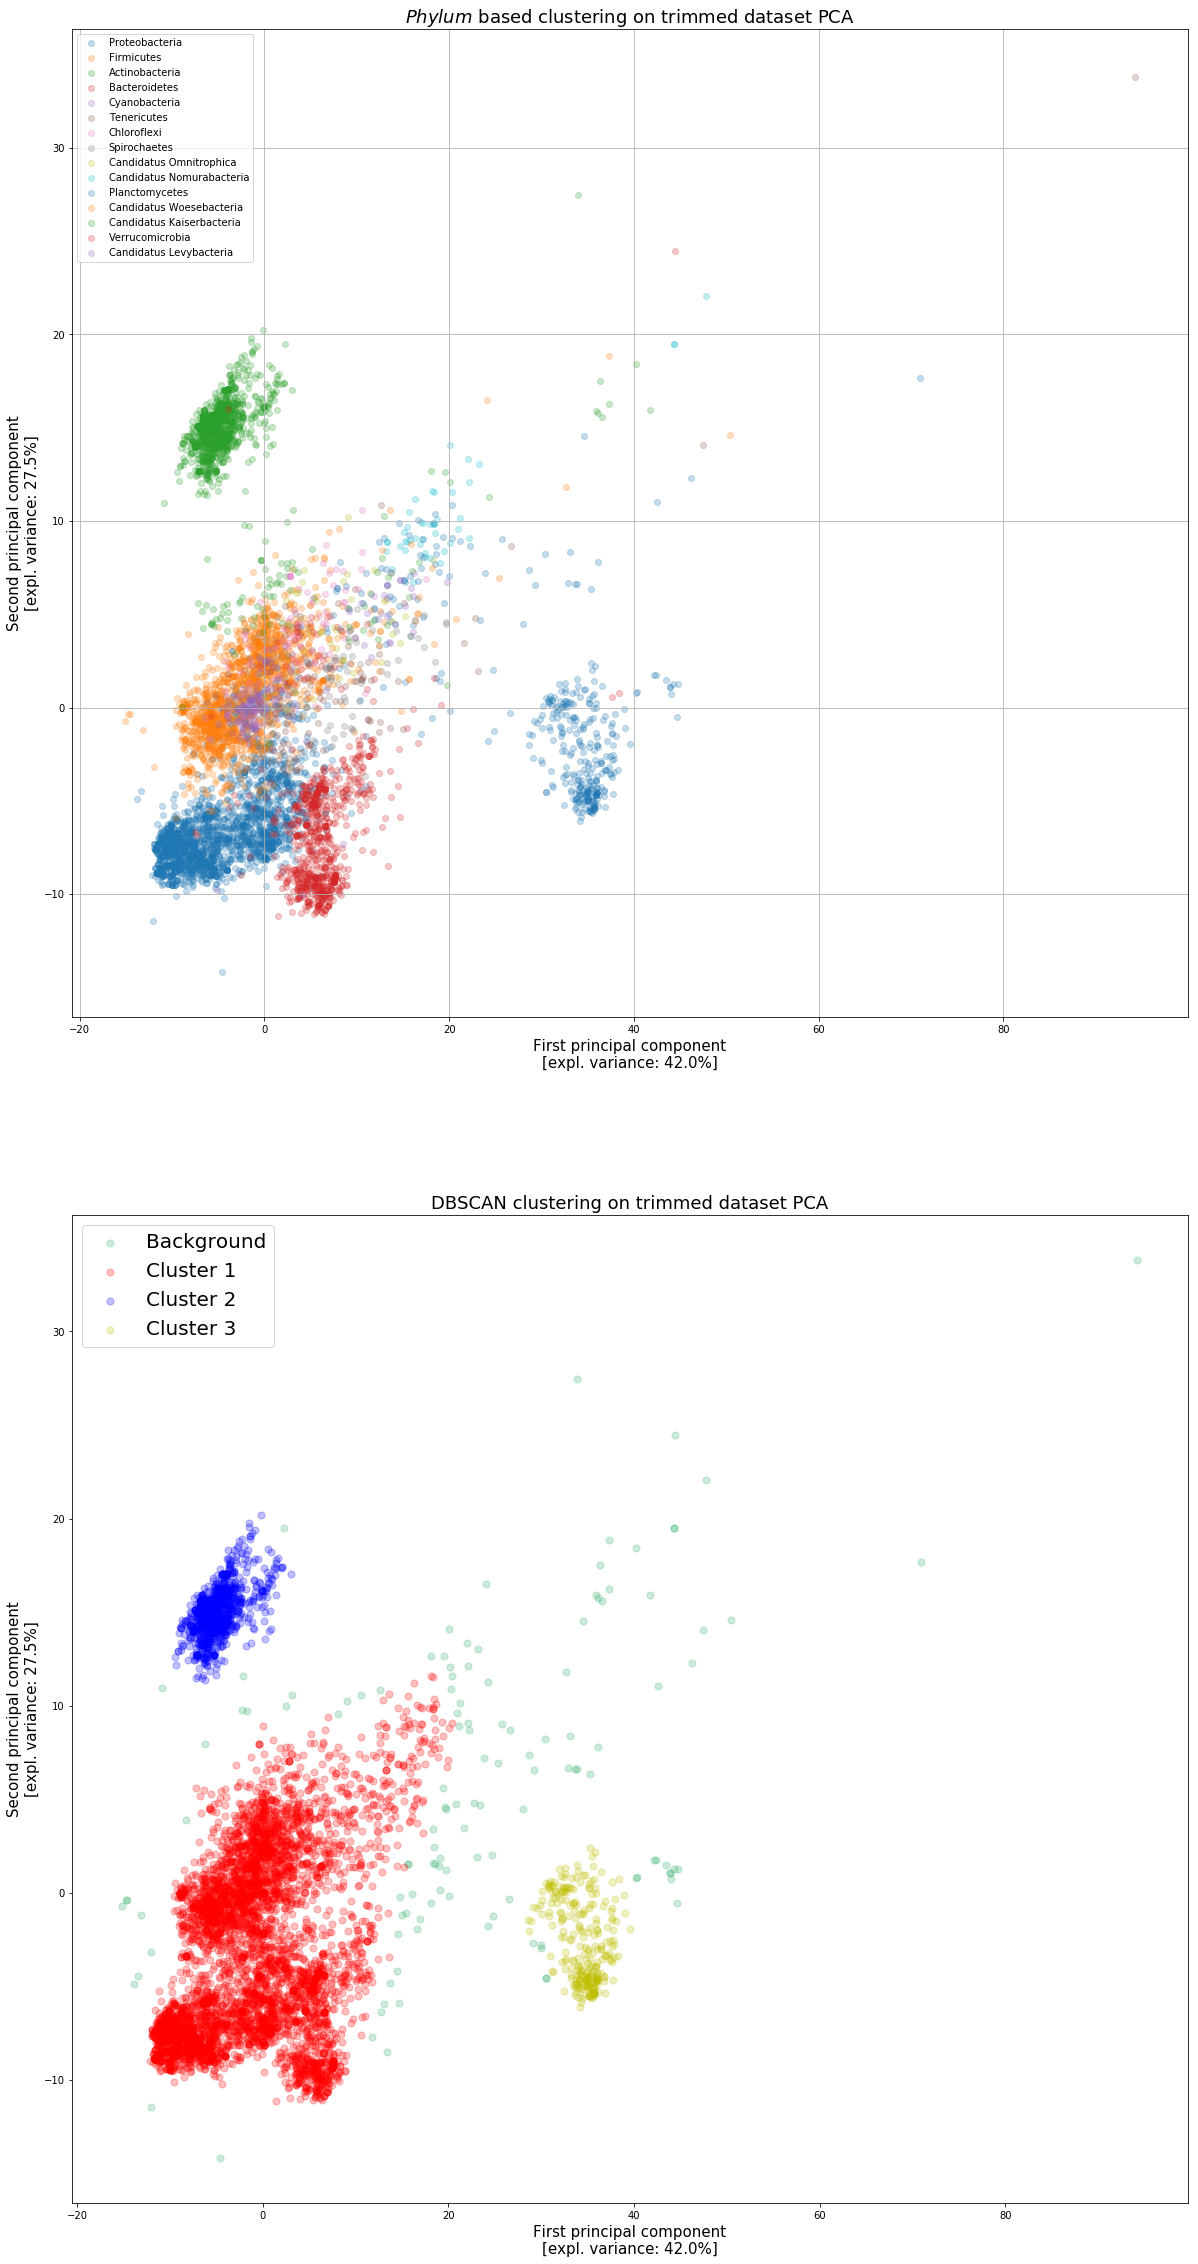

In [59]:
#dataframe_clean = final[final['phylum'].isin(phy_name_thresh)].reset_index()
#indexes_trimmed = []
#for phy in phy_name_thresh:
#    indexes_trimmed.append(dataframe_clean.index[dataframe_clean['phylum']==phy].tolist())


fig, (ax_t, ax_u) = plt.subplots(ncols = 1, nrows = 2, figsize = (20,40))

#phylum based clustering
for i_phy in range(len(phy_name_thresh)):
    data_plot = data_projected_clean[selection_90[i_phy]]
    ax_t.scatter(data_plot[:,0], data_plot[:,1], label=phy_name_thresh[i_phy], alpha=0.25)

ax_t.set_title(r"$Phylum$ based clustering on trimmed dataset PCA", fontsize=18)
ax_t.set_xlabel('First principal component\n[expl. variance: ' 
              + str("{:.1f}".format(pca_function2.explained_variance_ratio_[0]*100)) + '%]', fontsize = 15)
ax_t.set_ylabel('Second principal component\n[expl. variance: '
              + str("{:.1f}".format(pca_function2.explained_variance_ratio_[1]*100)) + '%]', fontsize = 15)
ax_t.grid()
ax_t.legend()

#unsupervised clustering, parameters to be chosen
#gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(data_projected_clean[:,0:2])
#gmm_cluster=gmm.predict(data_projected_clean[:,0:2])
#ax_u.scatter(data_projected_clean[:,0], data_projected_clean[:,1], c=gmm_cluster, cmap="Dark2", s=50, marker="o",alpha=1)
#ax_u.set_title(r"Gaussian micture clustering on trimmed dataset PCA", fontsize=18)
#ax_u.set_xlabel('First principal component\n[expl. variance: ' 
#              + str("{:.1f}".format(pca_function2.explained_variance_ratio_[0]*100)) + '%]', fontsize = 15)
#ax_u.set_ylabel('Second principal component\n[expl. variance: '
#              + str("{:.1f}".format(pca_function2.explained_variance_ratio_[1]*100)) + '%]', fontsize = 15)
#ax_u.grid()

#plt.show()

#unsupervised clustering, parameters to be chosen
db_func = DBSCAN(eps=1.6, min_samples=10).fit(data_projected_clean[:,0:2])
db_cluster=db_func.fit_predict(data_projected_clean[:,0:2])


for i in range(-1,3):
    if i==-1:
        ax_u.scatter(data_projected_clean[np.where(db_cluster==i),0], data_projected_clean[np.where(db_cluster==i),1], 
                 label="Background", s=50, marker="o",alpha=0.25, c=col[i+1])
    else:
        ax_u.scatter(data_projected_clean[np.where(db_cluster==i),0], data_projected_clean[np.where(db_cluster==i),1], 
                 label="Cluster "+str(i+1), s=50, marker="o",alpha=0.25, c=col[i+1])


    ax_u.set_title(r"DBSCAN clustering on trimmed dataset PCA", fontsize=18)
    ax_u.set_xlabel('First principal component\n[expl. variance: ' 
                  + str("{:.1f}".format(pca_function2.explained_variance_ratio_[0]*100)) + '%]', fontsize = 15)
    ax_u.set_ylabel('Second principal component\n[expl. variance: '
                  + str("{:.1f}".format(pca_function2.explained_variance_ratio_[1]*100)) + '%]', fontsize = 15)
    ax_u.grid()
    ax_u.legend(fontsize=20)

plt.show()

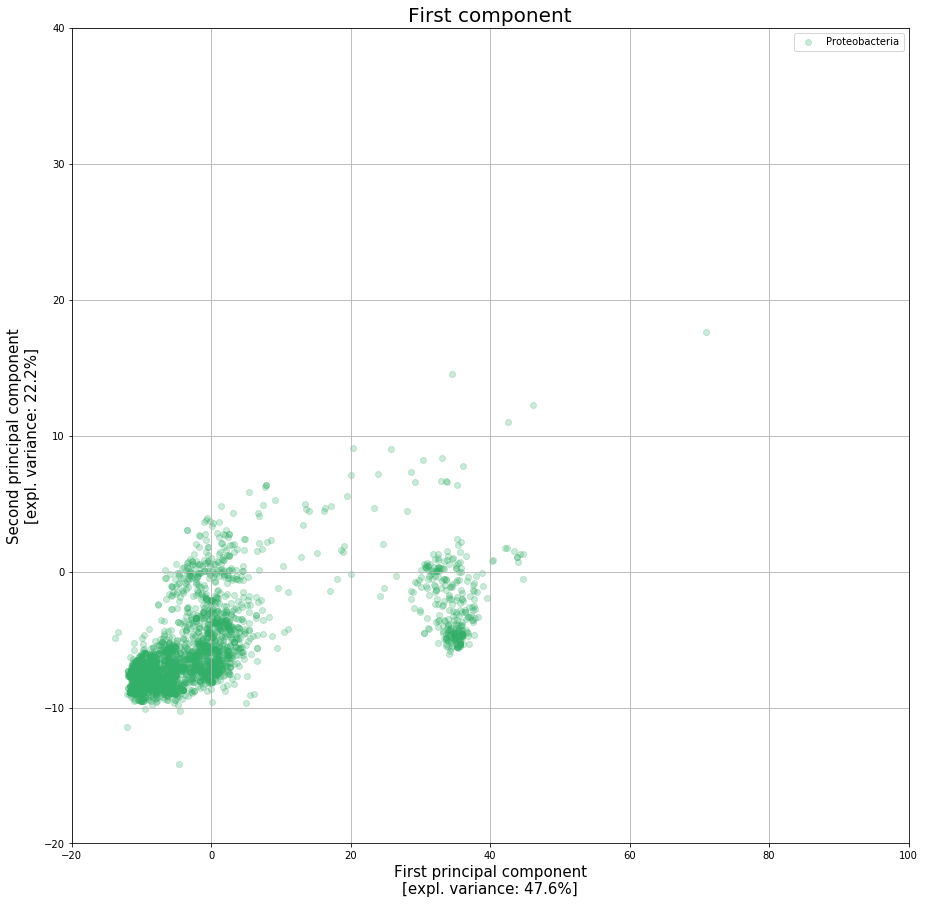

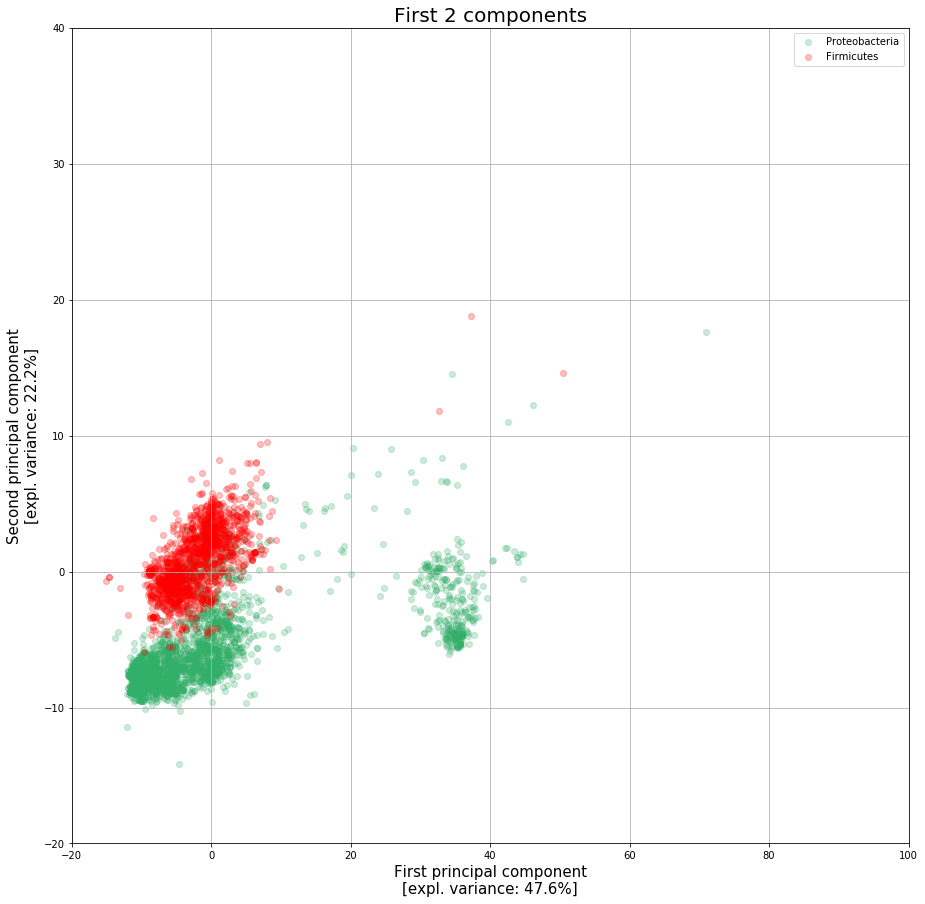

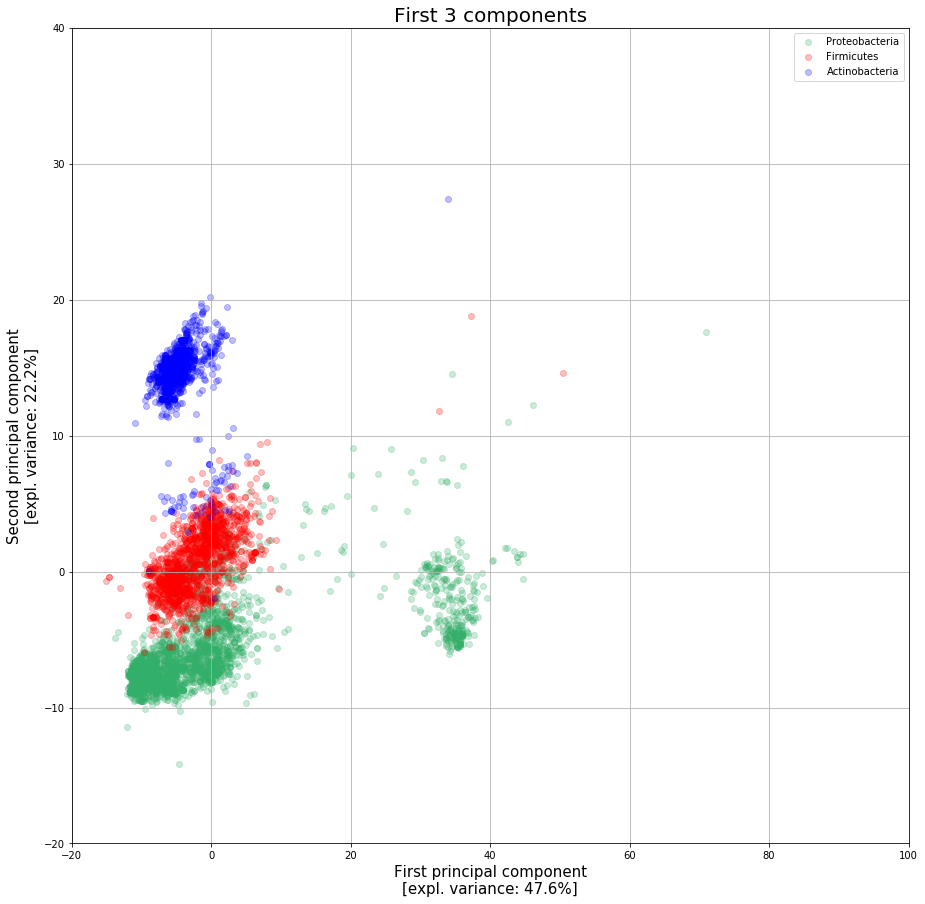

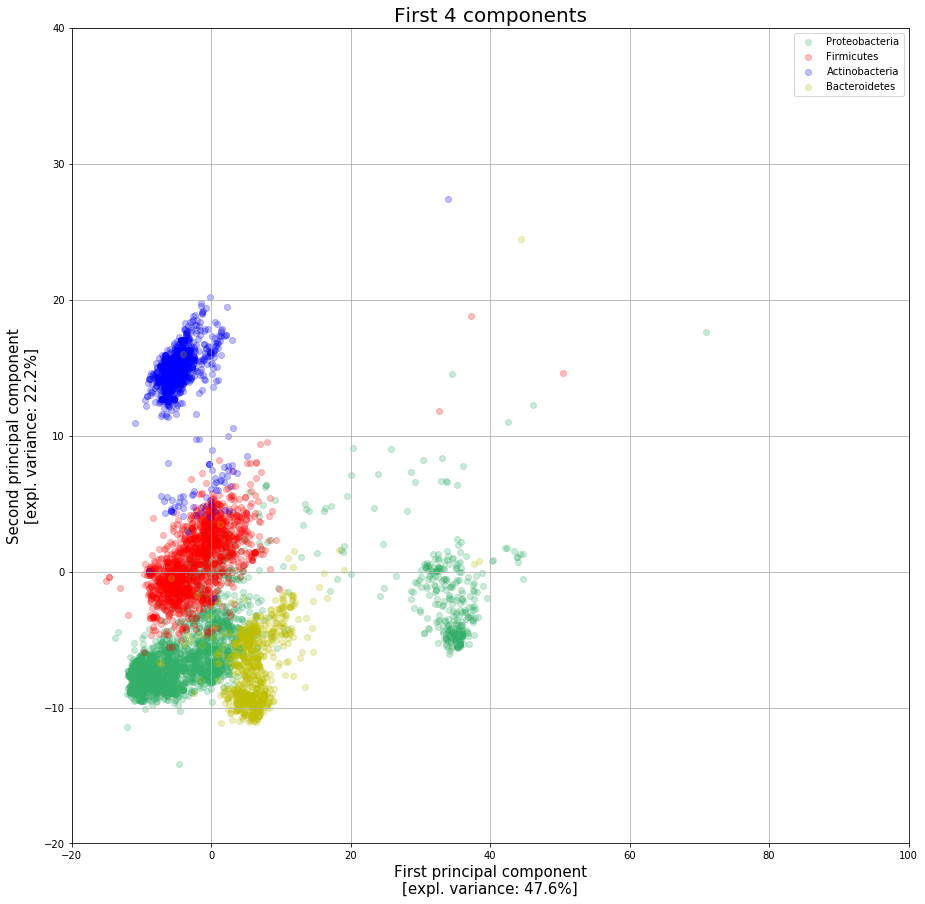

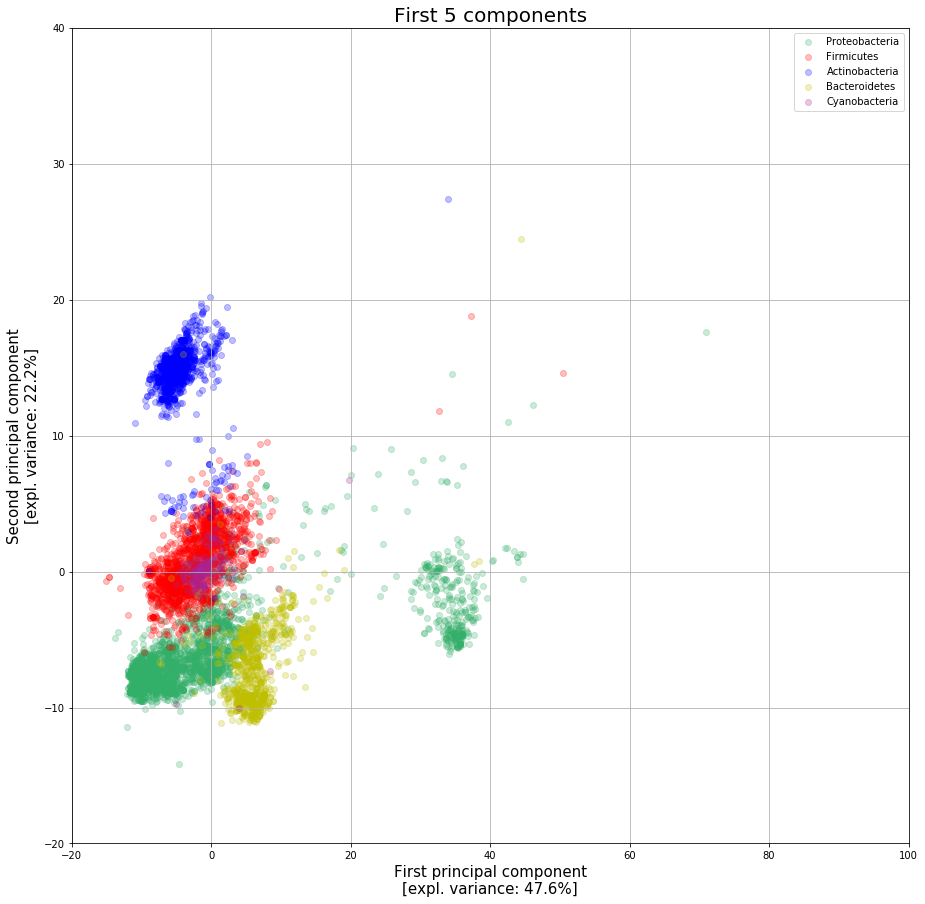

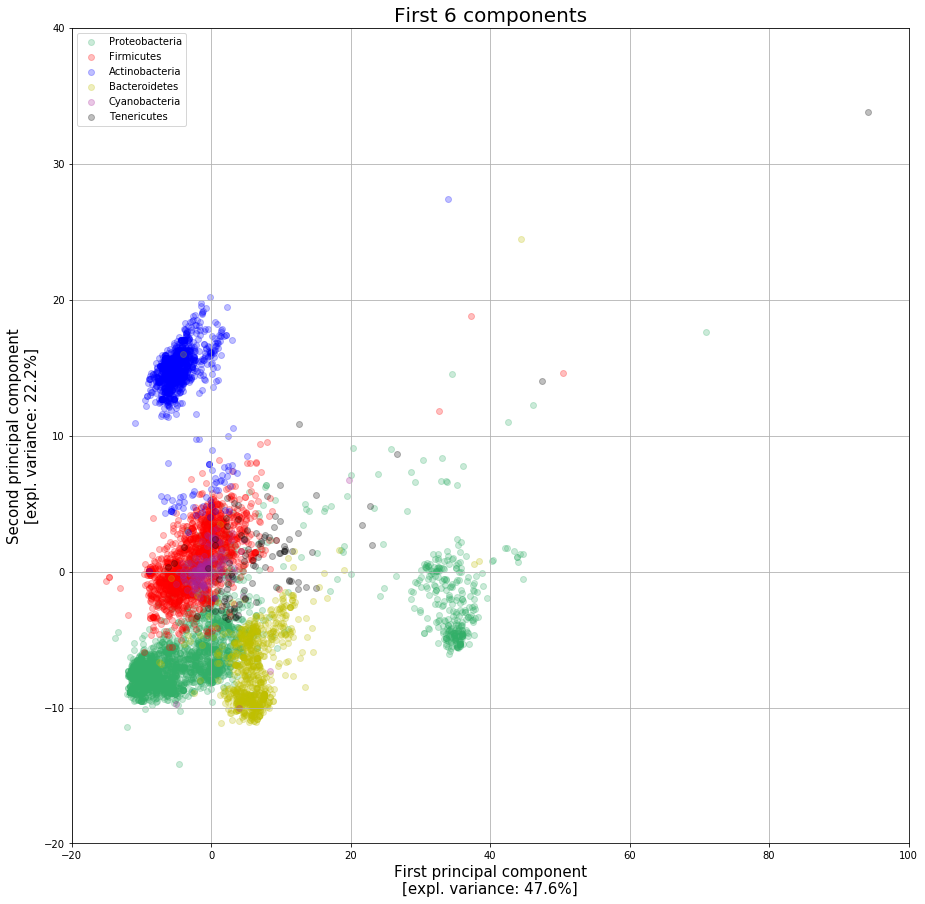

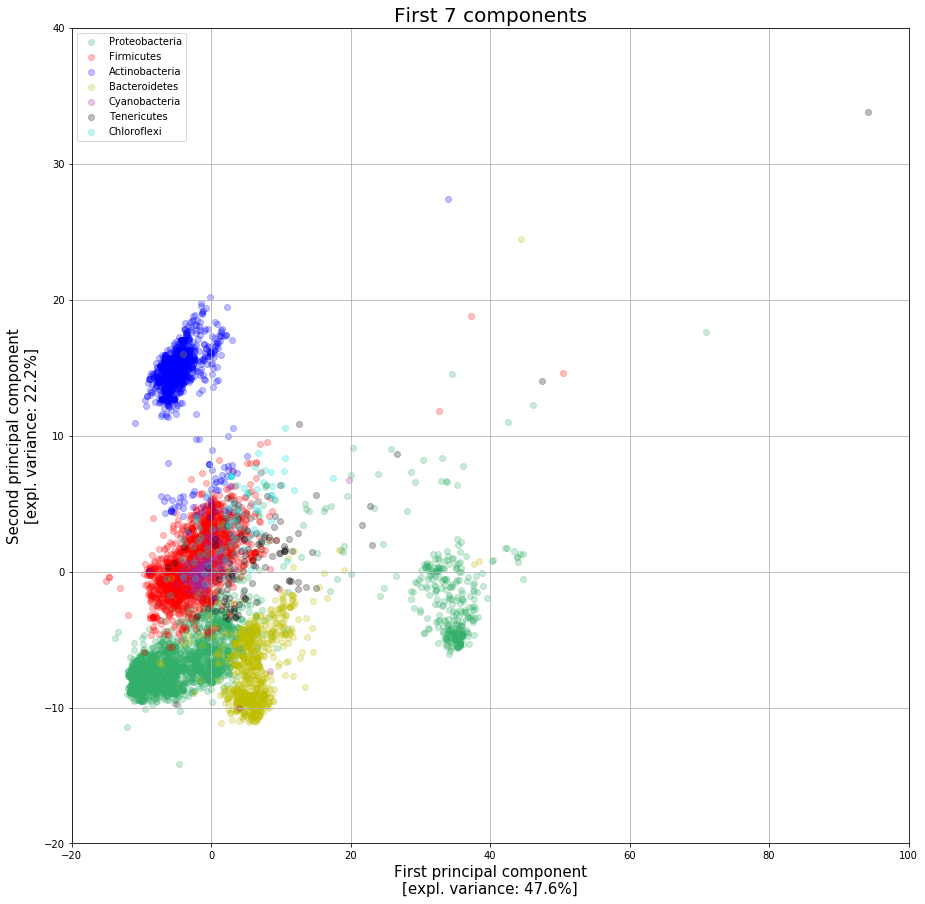

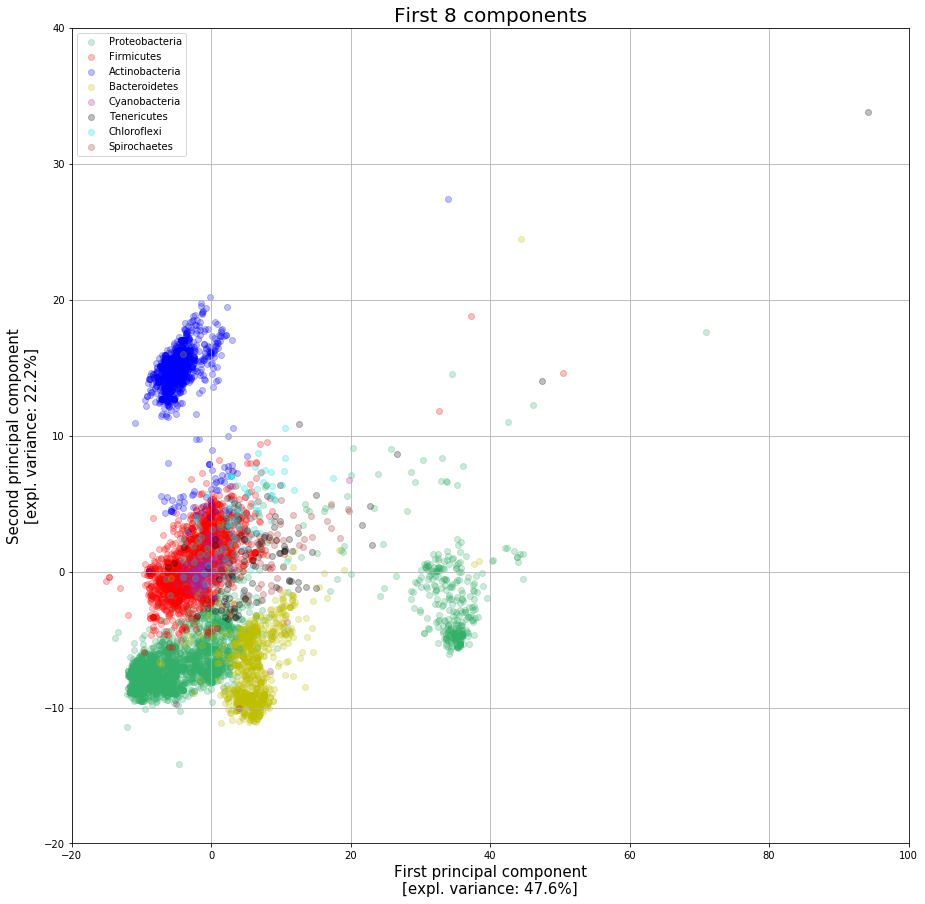

In [60]:
# fixing new intervals
boundx = [-20,100]
boundy = [-20,40]

A=pd.DataFrame(final).groupby(['phylum']).count().sort_values(by='lengths', ascending=False)['lengths']
cont=np.array(A)
cont

col=['#32af68','r','b','y','#aa2399','k','#00dddd','brown']


cluster2.sort(key=len,reverse=True)
label=phy_name_sort[0:9]

#for ca,a in enumerate(ax):
#    d=0
#    for clust in selection_90[:9]:
#        plot_data = data_projected_clean[clust]
#        if len(plot_data)>=len():
#            a.scatter(plot_data[:,0],plot_data[:,1], c=col[d], label=label[d], alpha=0.25)
#            a.set_ylim(boundy[0],boundy[1])
#            a.set_xlim(boundx[0],boundx[1])
#            a.set_xlabel('First principal component\n[expl. variance: ' + str("{:.1f}".format(pca_function.explained_variance_ratio_[0]*100)) + '%]', fontsize=15)
#            a.set_ylabel('Second principal component\n[expl. variance: '+ str("{:.1f}".format(pca_function.explained_variance_ratio_[1]*100)) + '%]', fontsize=15)
#            
#            a.legend()
#            
#            d+=1


for i in range(1,len(selection_90[:9])):
    plt.figure(figsize=(15,15))
    for j in range(i):
        plot_data = data_projected_clean[selection_90[j]]
        plt.scatter(plot_data[:,0],plot_data[:,1], c=col[j], label=label[j], alpha=0.25)
        plt.ylim(boundy[0],boundy[1])
        plt.xlim(boundx[0],boundx[1])
        if i == 1:
            plt.title("First component", fontsize=20)
        else:
            plt.title("First " + str(j+1) + " components", fontsize=20)
        plt.xlabel('First principal component\n[expl. variance: ' + str("{:.1f}".format(pca_function.explained_variance_ratio_[0]*100)) + '%]', fontsize=15)
        plt.ylabel('Second principal component\n[expl. variance: '+ str("{:.1f}".format(pca_function.explained_variance_ratio_[1]*100)) + '%]', fontsize=15)    
        plt.legend()
    plt.grid()
    plt.show()

In [61]:
final_clean=final.copy()

final_clean[data_projected_clean[:,0]!=0]=final.iloc[np.where(data_projected_clean[:,0]!=0)]
final_clean[data_projected_clean[:,0]==0]=np.NaN

In [62]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.2f}%".format(pct, absolute)

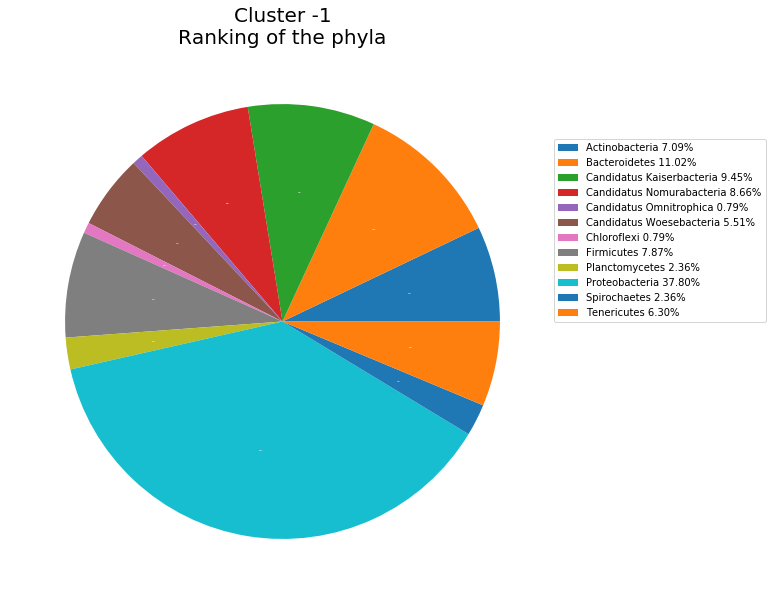

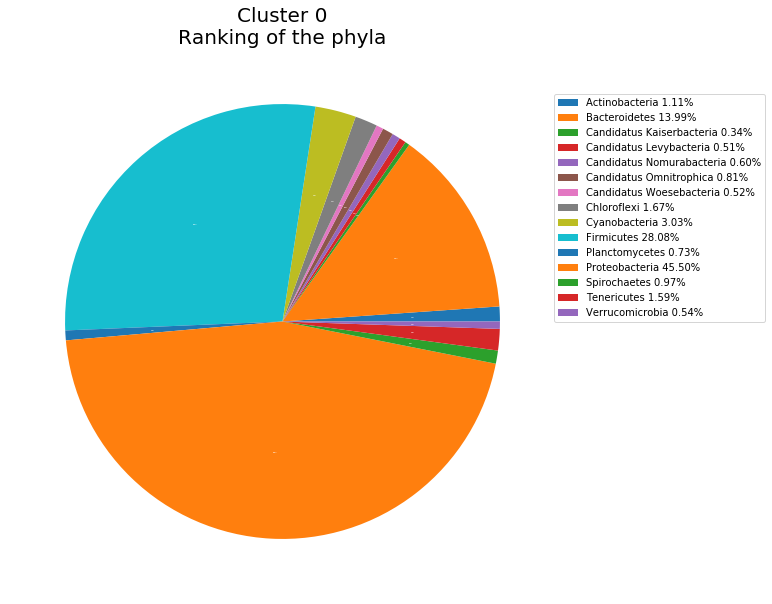

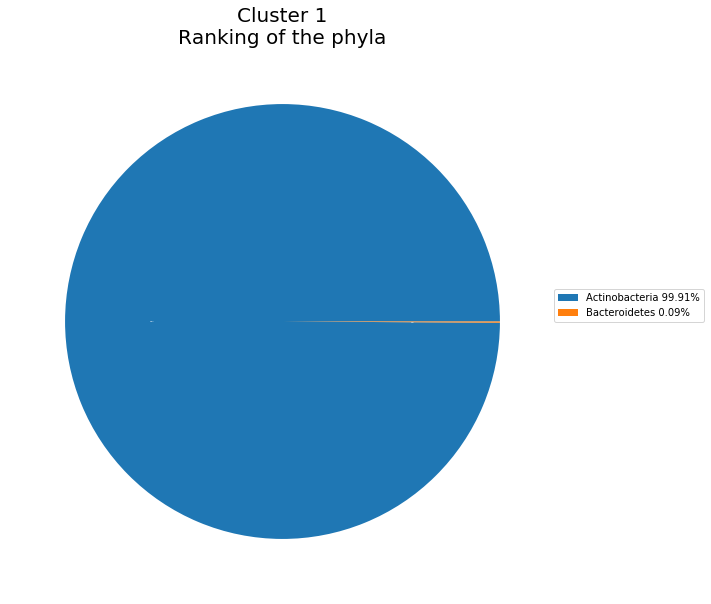

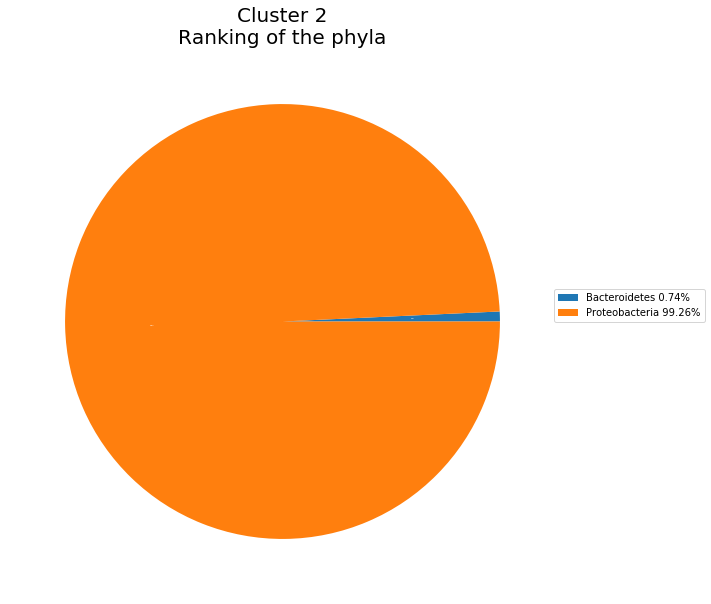

In [64]:
#ordering the phyla on the basis of the number of members in them
for i in range(-1,3):
    distr_phy_df=pd.DataFrame(final_clean.iloc[np.where(db_cluster==i)]).groupby(['phylum']).count()

    distribution1 = [distr_phy_df.index, distr_phy_df['lengths']]
    
    #plotting the resulting distribution
    plt.figure(figsize=(25,10))


    wedges, text, autotexts = plt.pie(distribution1[:][1],
                                      autopct=lambda pct: func(pct, distribution1[:][1]),textprops=dict(color="w"))

    plt.title(r'Cluster '+str(i)+'\nRanking of the phyla', fontsize=20)

    plt.setp(autotexts, size=0, weight="bold")
    
    perc = []
    for ele in autotexts:
        perc.append(str(ele)[str(ele).find("%")-5:str(ele).find("%")+1].replace("'", ""))
 
    current_labels=[]
    for j,k in zip(distribution1[:][0].tolist(),perc):
        current_labels.append(str(j)+str(" ")+str(k))
    plt.legend(loc=(1,0.5), ncol=1, borderaxespad=0., markerscale=2, labels=current_labels)
    plt.show()
    

# CONCLUSION

Since the results are not satisfying we choose to switch to another distance, the Damerau–Levenshtein. We develop our computations in another notebook for a better clarity of exposition.

# APPENDIX (to run transform markdown cells in code)

    def f1(smax,smin,lmax,lmin,pdef):
        for i in range(lmax-lmin+1): # for both straight + for one straight and the other reversed
            p=0
            for j in range(lmin):
                if smin[j]!=smax[i+j]:
                    p+=1/lmin
            if p<pdef:
                pdef=p
        return pdef


    def f2(smax,smin,lmin,pdef):
        for q in range(1,lmin): # for both straight + for both reversed + for one straight and one reversed + the opposite
            p=(lmin-q)/lmin
            for qq in range(q):
                if smin[lmin-q+qq]!=smax[qq]:
                    p+=1/lmin
            if p<pdef:
                pdef=p
        return pdef


    def distanza(s1,s2):
        lmin=min(len(s1),len(s2))
        lmax=max(len(s1),len(s2))
        if lmax==len(s1):
            smax=s1
            smin=s2
        else:
            smax=s2
            smin=s1   
        pdef=19/20 # we start from the value for which the logarithm is infinity, since we change only if is less
        pdef=f1(smax,smin,lmax,lmin,pdef)
        pdef=f1(smax,smin[::-1],lmax,lmin,pdef)
        pdef=f2(smax,smin,lmin,pdef)
        pdef=f2(smax[::-1],smin[::-1],lmin,pdef)
        pdef=f2(smax[::-1],smin,lmin,pdef)
        pdef=f2(smax,smin[::-1],lmin,pdef)
        d=(-19*np.log(1-20*pdef/19)/20)-np.log(1-(lmax-lmin)/(lmax+lmin))
        return d

    def q2(x,matrix,N):  
        for i in range(N):
            for j in range(i+1,N): # scroll only after the diagonal
                matrix[i][j]=distanza(x[i],x[j]) # compute half of the matrix
                matrix[j][i]=matrix[i][j] # complete the other half by symmetry, considering the diagonal is all zero
        return matrix

    sequenze=final.values[:,2]
    N=10 # we used a small number, so if someone wants to test it only generates a 10x10 matrix
    matrix=np.zeros((N,N))
    distmat=pd.DataFrame(q2(sequenze[:N],matrix,N))
    distmat